In [1]:
import os
import json
import matplotlib.pyplot as plt
import re
import seaborn as sns
import itertools
import math
import numpy as np
from tqdm import tqdm
import numpy as np

In [2]:
import os
import json
import pandas as pd

def load_metrics_in_order(task_dir):
    checkpoints = []
    checkpoint_ids = set()
    for task in ["task_a", "task_b"]:
        task_path = os.path.join(task_dir, task)
        if os.path.isdir(task_path):
            for filename in os.listdir(task_path):
                if filename.startswith("checkpoint-"):
                    try:
                        checkpoint_id = int(filename.replace("checkpoint-", ""))
                        checkpoint_ids.add(checkpoint_id)
                    except ValueError:
                        continue
    checkpoint_ids = sorted(checkpoint_ids)
    for ckpt_id in checkpoint_ids:
        metrics = {"checkpoint": ckpt_id}
        for task in ["task_a", "task_b"]:
            task_path = os.path.join(task_dir, task, f"checkpoint-{ckpt_id}", "metrics.json")
            if os.path.isfile(task_path):
                with open(task_path, "r") as f:
                    metrics[task] = json.load(f)
        checkpoints.append(metrics)
    return checkpoints

def load_all_tasks(base_dir):
    all_results = {}
    for dirname in os.listdir(base_dir):
        task_path = os.path.join(base_dir, dirname)
        if os.path.isdir(task_path):
            task_name = dirname.replace("->", "→")
            all_results[task_name] = load_metrics_in_order(task_path)
    return all_results

main_path = "/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false"
all_checkpoints = load_all_tasks(main_path)

selected_metrics = ["model_accuracy"]

rows = []
for task_name, ckpts in all_checkpoints.items():
    row = {"Experiment": task_name}

    start_ckpt = ckpts[0]
    end_ckpt = ckpts[-1]

    for task in ["task_a", "task_b"]:
        if task in start_ckpt and "model_accuracy" in start_ckpt[task]:
            row[f"{task.title().replace('_',' ')} Start Accuracy"] = start_ckpt[task]["model_accuracy"] * 100
        if task in end_ckpt and "model_accuracy" in end_ckpt[task]:
            row[f"{task.title().replace('_',' ')} End Accuracy"] = end_ckpt[task]["model_accuracy"] * 100

    rows.append(row)


In [4]:
rows = []

for exp_name, ckpts in all_checkpoints.items():
    task_a_name, task_b_name = exp_name.split("→")
    baseline_acc = None
    if "task_a" in ckpts[0] and "model_accuracy" in ckpts[0]["task_a"]:
        baseline_acc = ckpts[0]["task_a"]["model_accuracy"] * 100

    task_b_acc = None
    if "task_b" in ckpts[-1] and "model_accuracy" in ckpts[-1]["task_b"]:
        task_b_acc = ckpts[-1]["task_b"]["model_accuracy"] * 100

    if baseline_acc is not None and task_b_acc is not None:
        rows.append({
            "Subtask": exp_name,
            "Task A Name": task_a_name,
            "Task B Name": task_b_name,
            "Task A @ Ckpt0 (Baseline)": baseline_acc,
            "Task B Final Accuracy": task_b_acc,
            "Δ (B - A0)": round(task_b_acc - baseline_acc, 2)
        })

df_compare = pd.DataFrame(rows)
task_a_summary = (
    df_compare.groupby("Task A Name")["Task A @ Ckpt0 (Baseline)"]
    .agg(["mean"])
    .reset_index()
    .rename(columns={"mean": "Task A Baseline"})
)

df_merged = df_compare.merge(
    task_a_summary,
    left_on="Task B Name",
    right_on="Task A Name",
    how="left",
    suffixes=("", "_baseline_as_A")
)

df_merged["Δ (B vs baseline as A)"] = ((df_merged["Task B Final Accuracy"] - df_merged["Task A Baseline"])/df_merged["Task A Baseline"]) *100
df_result = df_merged[[
    "Subtask", "Task A Name", "Task B Name",
    "Task A @ Ckpt0 (Baseline)", "Task B Final Accuracy",
    "Task A Baseline", "Δ (B vs baseline as A)"
]]


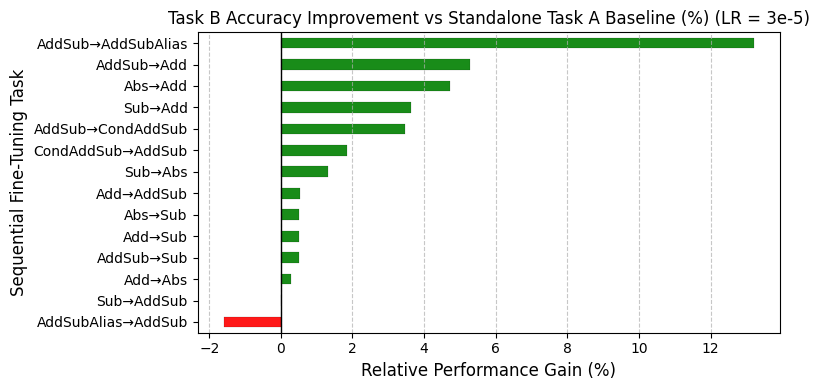

In [17]:
df_result = df_result.sort_values(by="Δ (B vs baseline as A)", ascending=True)

tasks_to_keep = ["AddSub→AddSubAlias", 
                 "AddSub→CondAddSub", 
                 "Add→Sub", 
                 "CondAddSub→AddSub",
                 "AddSubAlias→AddSub",
                 "Add→AddSub",
                 "Sub→AddSub",
                 "AddSub→Sub",
                 "AddSub→Add",
                 "Sub→Add",
                 "Abs→Add",
                 "Abs→Sub",
                 "Add→Abs",
                 "Sub→Abs"]
df_filtered = df_result[df_result["Subtask"].isin(tasks_to_keep)]

labels = df_filtered["Subtask"].tolist()
delta = df_filtered["Δ (B vs baseline as A)"].tolist()

colors = ['green' if x >= 0 else 'red' for x in delta]
height = 0.5
y = np.arange(len(labels))

plt.figure(figsize=(8, 4))
plt.barh(y, delta, height=height, color=colors, edgecolor="black", linewidth=0.1, alpha=0.9)

plt.yticks(y, labels)
plt.xlabel("Relative Performance Gain (%)", fontsize=12)
plt.ylabel("Sequential Fine-Tuning Task", fontsize=12)
plt.title("Task B Accuracy Improvement vs Standalone Task A Baseline (%) (LR = 3e-5)", fontsize=12)
plt.axvline(0, color="black", linewidth=1)
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("add_tasks_task_b_accuracy_gain_lr_true.pdf", format='pdf', dpi=600)
plt.show()

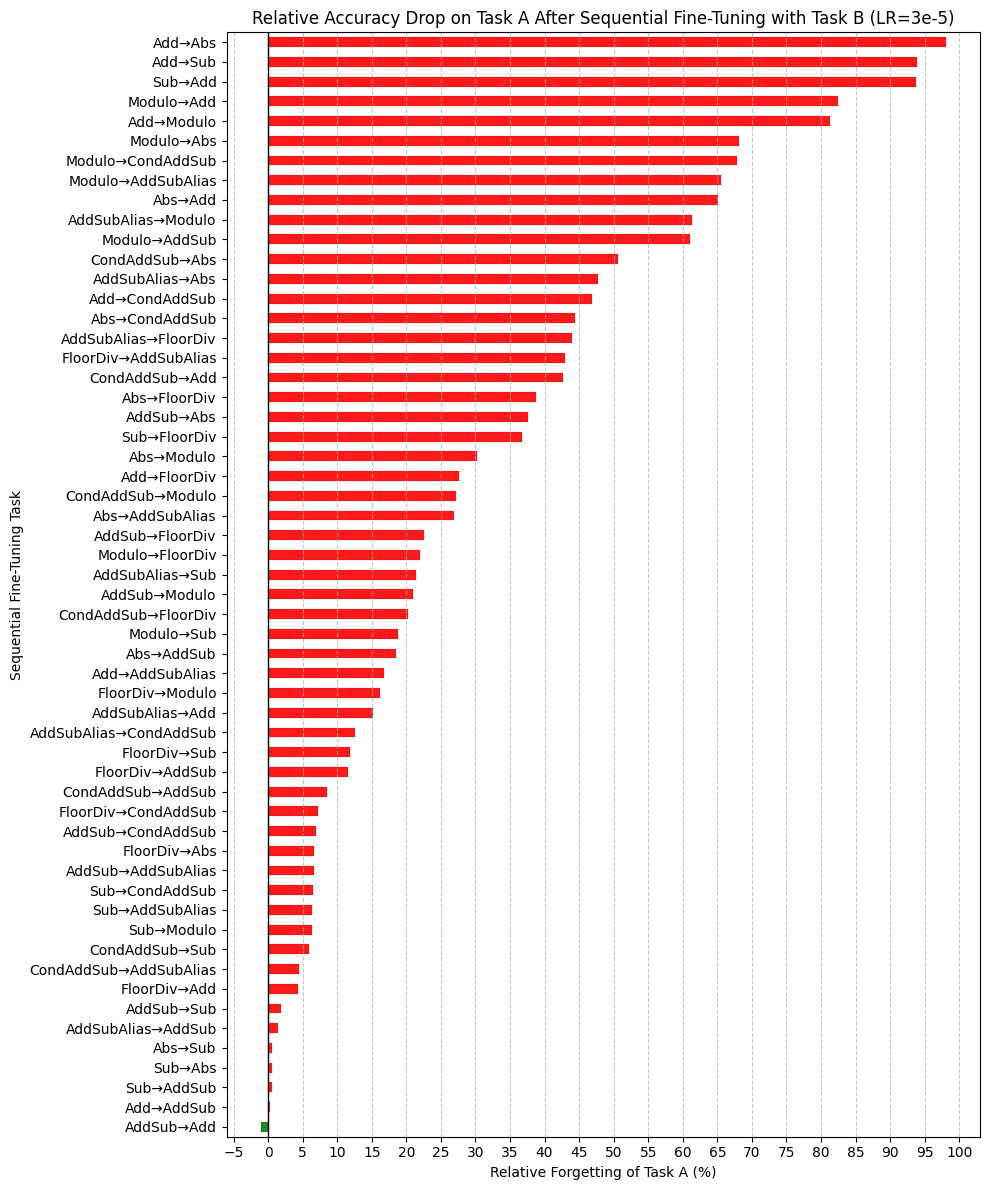

In [11]:
rows = []

for exp_name, ckpts in all_checkpoints.items():
    task_a_name, task_b_name = exp_name.split("→")

    baseline_acc_a = None
    if "task_a" in ckpts[0] and "model_accuracy" in ckpts[0]["task_a"]:
        baseline_acc_a = ckpts[0]["task_a"]["model_accuracy"]  # keep as fraction

    final_acc_a = None
    if "task_a" in ckpts[-1] and "model_accuracy" in ckpts[-1]["task_a"]:
        final_acc_a = ckpts[-1]["task_a"]["model_accuracy"]  # keep as fraction

    if baseline_acc_a is not None and final_acc_a is not None:
        forgetting_rel = (baseline_acc_a - final_acc_a) / baseline_acc_a * 100
        rows.append({
            "Subtask": exp_name,
            "Task A Name": task_a_name,
            "Task B Name": task_b_name,
            "Task A @ Ckpt0 (Baseline)": round(baseline_acc_a * 100, 2),
            "Task A Final Accuracy": round(final_acc_a * 100, 2),
            "Forgetting (A) %": round(forgetting_rel, 2)
        })

df_forgetting = pd.DataFrame(rows)
df_forgetting = df_forgetting.sort_values(by="Forgetting (A) %", ascending=True)

labels = df_forgetting["Subtask"].tolist()
delta_a = df_forgetting["Forgetting (A) %"].tolist()

colors = ['green' if x <= 0 else 'red' for x in delta_a] 
height = 0.5
y = np.arange(len(labels))

x_min = int(np.floor(min(delta_a) / 5) * 5)
x_max = int(np.ceil(max(delta_a) / 5) * 5) 

plt.figure(figsize=(10, 12))
plt.barh(y, delta_a, height=height, color=colors, edgecolor="black", linewidth=0.1, alpha=0.9)

plt.yticks(y, labels)
plt.xlabel("Relative Forgetting of Task A (%)")
plt.ylabel("Sequential Fine-Tuning Task")
plt.title("Relative Accuracy Drop on Task A After Sequential Fine-Tuning with Task B (LR=3e-5)")
plt.axvline(0, color="black", linewidth=1)
plt.ylim(y.min() - 0.5, y.max() + 0.5)

plt.xticks(np.arange(x_min, x_max + 5, 5))

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("task_a_forgetting_relative_lr_true.pdf", format='pdf', dpi=600)
plt.show()

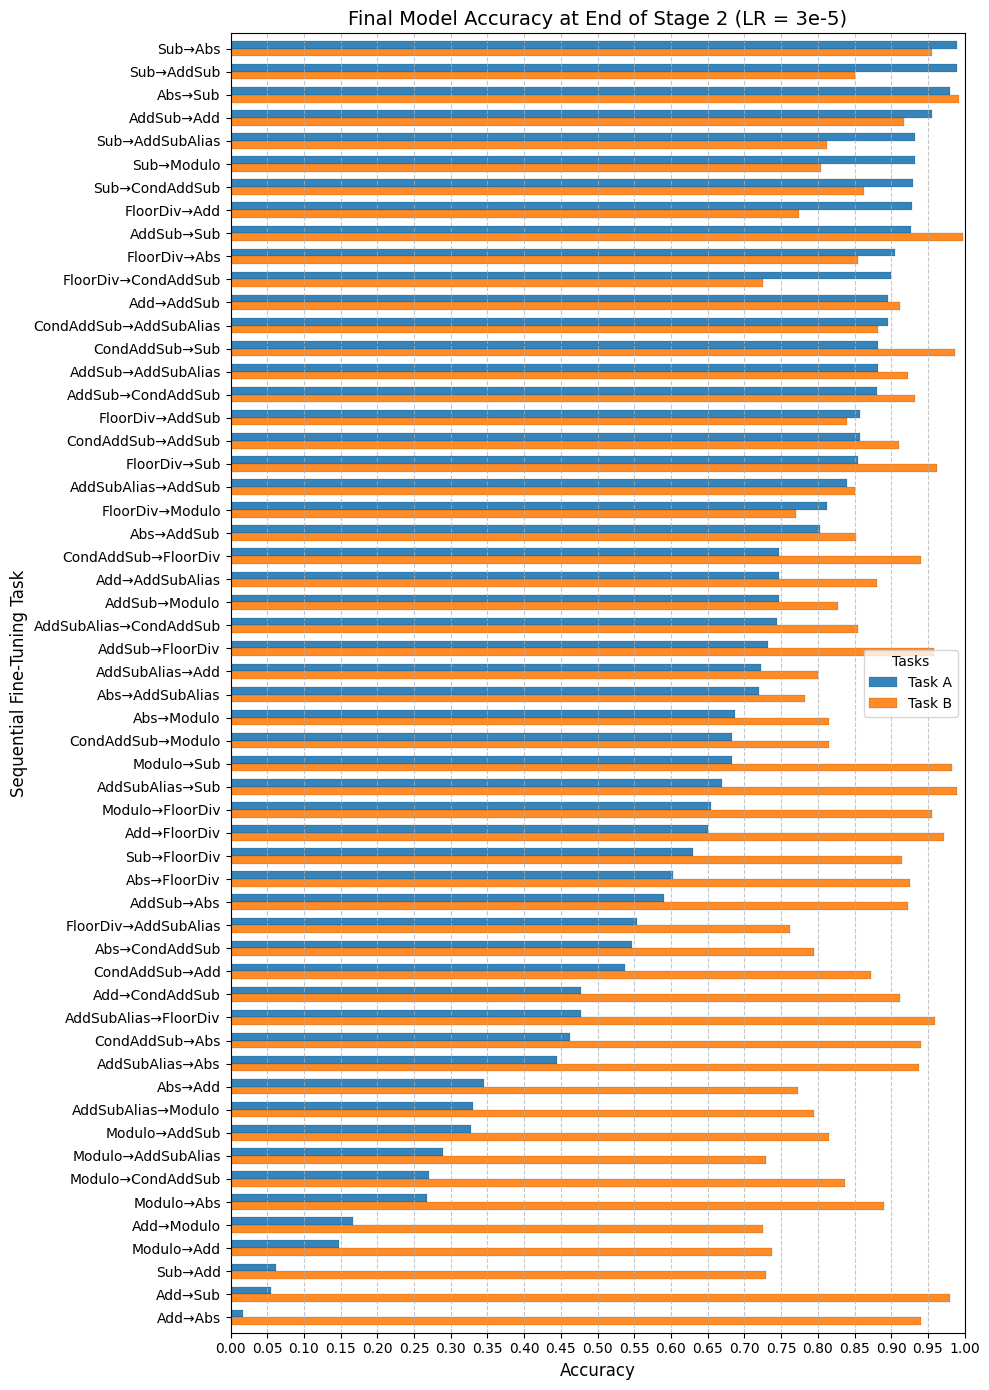

In [3]:
data = []
for task_name, checkpoints in all_checkpoints.items():
    if checkpoints:
        last = checkpoints[-1]
        data.append({
            "Task Pair": task_name,
            "Task A": last.get("task_a", {}).get("model_accuracy", 0),
            "Task B": last.get("task_b", {}).get("model_accuracy", 0)
        })

df = pd.DataFrame(data)
df = df.sort_values(by="Task A", ascending=True)

labels = df["Task Pair"].tolist()
task_a_acc = df["Task A"].tolist()
task_b_acc = df["Task B"].tolist()

height = 0.5 

y = np.arange(len(labels)) * 1.5
plt.figure(figsize=(10,14))
plt.barh(y + height/2, task_a_acc, height=height, label="Task A", edgecolor="black", linewidth=0.1, alpha=0.9)
plt.barh(y - height/2, task_b_acc, height=height, label="Task B", edgecolor="black", linewidth=0.1, alpha=0.9)

plt.yticks(y, labels)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Sequential Fine-Tuning Task", fontsize=12)
plt.title("Final Model Accuracy at End of Stage 2 (LR = 3e-5)", fontsize=14)
plt.legend(title="Tasks")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.xlim(0, 1) 
plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylim(y.min() - 1, y.max() + 1)

plt.tight_layout()
plt.savefig("task_b_accuracy_lr_true.pdf", format='pdf', dpi=600)
plt.show()

In [2]:
def load_checkpoints_in_order(task_dir):
    checkpoints = []
    checkpoint_files = []

    for filename in os.listdir(task_dir):
        checkpoint_path = os.path.join(task_dir, filename)
        
        if os.path.isdir(checkpoint_path) and filename.startswith('checkpoint-'):
            try:
                checkpoint_id = int(filename.replace('checkpoint-', ''))
                graph_path = os.path.join(checkpoint_path, 'graph.json')
                if os.path.isfile(graph_path):
                    checkpoint_files.append((checkpoint_id, graph_path))
            except ValueError:
                continue 

    checkpoint_files.sort(key=lambda x: x[0])

    for _, json_path in checkpoint_files:
        with open(json_path, 'r') as f:
            data = json.load(f)
            checkpoints.append(data)

    return checkpoints

In [4]:
def count_nodes_per_checkpoint(checkpoints):
    node_counts = []
    for checkpoint in checkpoints:
        nodes = checkpoint['nodes']
        true_count = sum(1 for node, state in nodes.items() if state)
        node_counts.append(true_count)
    return node_counts

def calculate_node_changes(checkpoints):
    changes = []
    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']
        added = sum(
            1 for node in curr_nodes
            if curr_nodes[node].get('in_graph', False) and not prev_nodes.get(node, {}).get('in_graph', False)
        )       

        removed = sum(
            1 for node in prev_nodes
            if prev_nodes[node].get('in_graph', False) and not curr_nodes.get(node, {}).get('in_graph', False)
        )
        changes.append(added + removed)

    return changes

def calculate_edge_overlap_topk(checkpoints, topk_percent=0.05):
    overlaps = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']

        def topk_edges(edges, percent):
            k = max(1, int(len(edges) * percent))
            sorted_edges = sorted(edges.items(), key=lambda item: abs(item[1].get('score', 0)), reverse=True)
            top_edges = set(edge for edge, data in sorted_edges[:k])
            return top_edges

        prev_top = topk_edges(prev_edges, topk_percent)
        curr_top = topk_edges(curr_edges, topk_percent)

        overlap_count = len(prev_top & curr_top)
        k = max(len(prev_top), len(curr_top))
        overlap_fraction = overlap_count / k
        overlaps.append(overlap_fraction)

        print(f"Overlap: {overlap_count}, Top-k Size: {k}, Fraction: {overlap_fraction:.3f}")

    return overlaps

def calculate_edge_changes_topk(checkpoints, topk_percent=0.05):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']

        def topk_edges(edges, percent):
            k = max(1, int(len(edges) * percent))
            sorted_edges = sorted(edges.items(), key=lambda item: abs(item[1].get('score', 0)), reverse=True)
            top_edges = set(edge for edge, data in sorted_edges[:k])
            return top_edges, k

        prev_top, k = topk_edges(prev_edges, topk_percent)
        curr_top, _ = topk_edges(curr_edges, topk_percent)
        overlap = len(prev_top & curr_top)
        actual_changes = k - overlap 

        normalized_change = actual_changes / k
        changes.append(normalized_change)

        print(f"Top-k Size: {k}, Overlap: {overlap}, Changes: {actual_changes}, Normalized: {normalized_change:.3f}")

    return changes

In [ ]:
main_path = "/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false"
all_checkpoints = load_all_tasks(main_path)

selected_metrics = ["model_accuracy"]

rows = []
for task_name, ckpts in all_checkpoints.items():
    row = {"Experiment": task_name}

    start_ckpt = ckpts[0]
    end_ckpt = ckpts[-1]

    for task in ["task_a", "task_b"]:
        if task in start_ckpt and "model_accuracy" in start_ckpt[task]:
            row[f"{task.title().replace('_',' ')} Start Accuracy"] = start_ckpt[task]["model_accuracy"]
        if task in end_ckpt and "model_accuracy" in end_ckpt[task]:
            row[f"{task.title().replace('_',' ')} End Accuracy"] = end_ckpt[task]["model_accuracy"]

    rows.append(row)

rows_forgetting = []
for exp_name, ckpts in all_checkpoints.items():
    start_acc = ckpts[0].get("task_a", {}).get("model_accuracy", None)
    end_acc = ckpts[-1].get("task_a", {}).get("model_accuracy", None)
    if start_acc is not None and end_acc is not None:
        forgetting_rel = (start_acc - end_acc) / start_acc
        rows_forgetting.append({
            "Experiment": exp_name,
            "Task A Forgetting (%)": forgetting_rel
        })

df_forgetting = pd.DataFrame(rows_forgetting)

tasks = []
task_labels = []

for root, dirs, files in os.walk(main_path):
    if os.path.basename(root) == "task_b":
        tasks.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels.append(label.replace("->", "→"))

counts = []
for task in tqdm(tasks):
    loaded_checkpoints = load_checkpoints_in_order(task)
    print(task)
    in_graph_changes = calculate_edge_overlap_topk(loaded_checkpoints)
    counts.append(in_graph_changes[0]) 

df_counts = pd.DataFrame({
    "Experiment": task_labels,
    "Task A Edge Change": counts
})
df_combined = pd.merge(df_forgetting, df_counts, on="Experiment")
print(df_combined)

  0%|          | 0/55 [00:00<?, ?it/s]

/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->AddSub/task_a


  2%|▏         | 1/55 [00:06<05:24,  6.01s/it]

Top-k Size: 11574, Overlap: 8197, Changes: 3377, Normalized: 0.292
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/CondAddSub->AddSubAlias/task_a


  4%|▎         | 2/55 [00:12<05:22,  6.08s/it]

Top-k Size: 11574, Overlap: 7336, Changes: 4238, Normalized: 0.366
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->Modulo/task_a


  5%|▌         | 3/55 [00:17<05:08,  5.94s/it]

Top-k Size: 11574, Overlap: 6318, Changes: 5256, Normalized: 0.454
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->AddSubAlias/task_a


  7%|▋         | 4/55 [00:23<04:59,  5.88s/it]

Top-k Size: 11574, Overlap: 6124, Changes: 5450, Normalized: 0.471
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->Modulo/task_a


  9%|▉         | 5/55 [00:29<04:51,  5.83s/it]

Top-k Size: 11574, Overlap: 6443, Changes: 5131, Normalized: 0.443
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->Add/task_a


 11%|█         | 6/55 [00:34<04:38,  5.68s/it]

Top-k Size: 11574, Overlap: 7937, Changes: 3637, Normalized: 0.314
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/CondAddSub->Add/task_a


 13%|█▎        | 7/55 [00:40<04:32,  5.68s/it]

Top-k Size: 11574, Overlap: 6973, Changes: 4601, Normalized: 0.398
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->FloorDiv/task_a


 15%|█▍        | 8/55 [00:46<04:29,  5.73s/it]

Top-k Size: 11574, Overlap: 6582, Changes: 4992, Normalized: 0.431
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->Abs/task_a


 16%|█▋        | 9/55 [00:51<04:14,  5.53s/it]

Top-k Size: 11574, Overlap: 6513, Changes: 5061, Normalized: 0.437
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->Sub/task_a


 18%|█▊        | 10/55 [00:57<04:14,  5.66s/it]

Top-k Size: 11574, Overlap: 6201, Changes: 5373, Normalized: 0.464
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->Modulo/task_a


 20%|██        | 11/55 [01:02<04:06,  5.61s/it]

Top-k Size: 11574, Overlap: 5507, Changes: 6067, Normalized: 0.524
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->Modulo/task_a


 22%|██▏       | 12/55 [01:08<04:00,  5.59s/it]

Top-k Size: 11574, Overlap: 5294, Changes: 6280, Normalized: 0.543
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->CondAddSub/task_a


 24%|██▎       | 13/55 [01:13<03:54,  5.58s/it]

Top-k Size: 11574, Overlap: 7133, Changes: 4441, Normalized: 0.384
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->Sub/task_a


 25%|██▌       | 14/55 [01:19<03:46,  5.52s/it]

Top-k Size: 11574, Overlap: 7974, Changes: 3600, Normalized: 0.311
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/CondAddSub->AddSub/task_a


 27%|██▋       | 15/55 [01:24<03:33,  5.33s/it]

Top-k Size: 11574, Overlap: 7596, Changes: 3978, Normalized: 0.344
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->AddSubAlias/task_a


 29%|██▉       | 16/55 [01:29<03:30,  5.40s/it]

Top-k Size: 11574, Overlap: 7699, Changes: 3875, Normalized: 0.335
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->FloorDiv/task_a


 31%|███       | 17/55 [01:35<03:27,  5.45s/it]

Top-k Size: 11574, Overlap: 5572, Changes: 6002, Normalized: 0.519
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->FloorDiv/task_a


 33%|███▎      | 18/55 [01:38<03:00,  4.87s/it]

Top-k Size: 11574, Overlap: 6939, Changes: 4635, Normalized: 0.400
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->Sub/task_a


 35%|███▍      | 19/55 [01:42<02:45,  4.61s/it]

Top-k Size: 11574, Overlap: 8343, Changes: 3231, Normalized: 0.279
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->Abs/task_a


 36%|███▋      | 20/55 [01:47<02:46,  4.74s/it]

Top-k Size: 11574, Overlap: 6264, Changes: 5310, Normalized: 0.459
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->Modulo/task_a


 38%|███▊      | 21/55 [01:53<02:53,  5.10s/it]

Top-k Size: 11574, Overlap: 5745, Changes: 5829, Normalized: 0.504
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->Sub/task_a


 40%|████      | 22/55 [01:59<02:54,  5.28s/it]

Top-k Size: 11574, Overlap: 6571, Changes: 5003, Normalized: 0.432
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->AddSub/task_a


 42%|████▏     | 23/55 [02:04<02:49,  5.28s/it]

Top-k Size: 11574, Overlap: 6954, Changes: 4620, Normalized: 0.399
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->AddSubAlias/task_a


 44%|████▎     | 24/55 [02:09<02:41,  5.21s/it]

Top-k Size: 11574, Overlap: 6751, Changes: 4823, Normalized: 0.417
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->CondAddSub/task_a


 45%|████▌     | 25/55 [02:15<02:35,  5.19s/it]

Top-k Size: 11574, Overlap: 6085, Changes: 5489, Normalized: 0.474
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/CondAddSub->Sub/task_a


 47%|████▋     | 26/55 [02:20<02:33,  5.30s/it]

Top-k Size: 11574, Overlap: 7302, Changes: 4272, Normalized: 0.369
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->Add/task_a


 49%|████▉     | 27/55 [02:26<02:30,  5.38s/it]

Top-k Size: 11574, Overlap: 6411, Changes: 5163, Normalized: 0.446
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->AddSub/task_a


 51%|█████     | 28/55 [02:31<02:26,  5.42s/it]

Top-k Size: 11574, Overlap: 6400, Changes: 5174, Normalized: 0.447
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->AddSub/task_a


 53%|█████▎    | 29/55 [02:37<02:20,  5.39s/it]

Top-k Size: 11574, Overlap: 8532, Changes: 3042, Normalized: 0.263
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->AddSubAlias/task_a


 55%|█████▍    | 30/55 [02:42<02:13,  5.35s/it]

Top-k Size: 11574, Overlap: 8036, Changes: 3538, Normalized: 0.306
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->AddSub/task_a


 56%|█████▋    | 31/55 [02:47<02:08,  5.35s/it]

Top-k Size: 11574, Overlap: 7258, Changes: 4316, Normalized: 0.373
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Add->CondAddSub/task_a


 58%|█████▊    | 32/55 [02:53<02:04,  5.43s/it]

Top-k Size: 11574, Overlap: 6817, Changes: 4757, Normalized: 0.411
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->Add/task_a


 60%|██████    | 33/55 [02:58<02:00,  5.46s/it]

Top-k Size: 11574, Overlap: 6247, Changes: 5327, Normalized: 0.460
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->AddSubAlias/task_a


 62%|██████▏   | 34/55 [03:04<01:54,  5.46s/it]

Top-k Size: 11574, Overlap: 5509, Changes: 6065, Normalized: 0.524
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->CondAddSub/task_a


 64%|██████▎   | 35/55 [03:09<01:49,  5.49s/it]

Top-k Size: 11574, Overlap: 6587, Changes: 4987, Normalized: 0.431
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->Add/task_a


 65%|██████▌   | 36/55 [03:14<01:41,  5.34s/it]

Top-k Size: 11574, Overlap: 6732, Changes: 4842, Normalized: 0.418
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->Add/task_a


 67%|██████▋   | 37/55 [03:20<01:37,  5.39s/it]

Top-k Size: 11574, Overlap: 5126, Changes: 6448, Normalized: 0.557
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->Abs/task_a


 69%|██████▉   | 38/55 [03:25<01:32,  5.41s/it]

Top-k Size: 11574, Overlap: 5733, Changes: 5841, Normalized: 0.505
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->CondAddSub/task_a


 71%|███████   | 39/55 [03:29<01:20,  5.06s/it]

Top-k Size: 11574, Overlap: 5469, Changes: 6105, Normalized: 0.527
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->AddSub/task_a


 73%|███████▎  | 40/55 [03:33<01:08,  4.59s/it]

Top-k Size: 11574, Overlap: 5469, Changes: 6105, Normalized: 0.527
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->AddSubAlias/task_a


 75%|███████▍  | 41/55 [03:37<00:59,  4.28s/it]

Top-k Size: 11574, Overlap: 8266, Changes: 3308, Normalized: 0.286
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Modulo->Sub/task_a


 76%|███████▋  | 42/55 [03:42<00:59,  4.55s/it]

Top-k Size: 11574, Overlap: 5804, Changes: 5770, Normalized: 0.499
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->CondAddSub/task_a


 78%|███████▊  | 43/55 [03:47<00:57,  4.83s/it]

Top-k Size: 11574, Overlap: 7480, Changes: 4094, Normalized: 0.354
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/FloorDiv->Sub/task_a


 80%|████████  | 44/55 [03:53<00:55,  5.02s/it]

Top-k Size: 11574, Overlap: 5935, Changes: 5639, Normalized: 0.487
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->Modulo/task_a


 82%|████████▏ | 45/55 [03:58<00:51,  5.20s/it]

Top-k Size: 11574, Overlap: 6517, Changes: 5057, Normalized: 0.437
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->CondAddSub/task_a


 84%|████████▎ | 46/55 [04:04<00:48,  5.35s/it]

Top-k Size: 11574, Overlap: 7158, Changes: 4416, Normalized: 0.382
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->Abs/task_a


 85%|████████▌ | 47/55 [04:10<00:43,  5.44s/it]

Top-k Size: 11574, Overlap: 6449, Changes: 5125, Normalized: 0.443
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->Add/task_a


 87%|████████▋ | 48/55 [04:15<00:38,  5.46s/it]

Top-k Size: 11574, Overlap: 6290, Changes: 5284, Normalized: 0.457
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Abs->FloorDiv/task_a


 89%|████████▉ | 49/55 [04:19<00:29,  4.92s/it]

Top-k Size: 11574, Overlap: 6713, Changes: 4861, Normalized: 0.420
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/Sub->Abs/task_a


 91%|█████████ | 50/55 [04:24<00:24,  4.97s/it]

Top-k Size: 11574, Overlap: 8106, Changes: 3468, Normalized: 0.300
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/CondAddSub->Abs/task_a


 93%|█████████▎| 51/55 [04:29<00:20,  5.06s/it]

Top-k Size: 11574, Overlap: 7182, Changes: 4392, Normalized: 0.379
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->Abs/task_a


 95%|█████████▍| 52/55 [04:35<00:15,  5.27s/it]

Top-k Size: 11574, Overlap: 7384, Changes: 4190, Normalized: 0.362
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSub->FloorDiv/task_a


 96%|█████████▋| 53/55 [04:40<00:10,  5.27s/it]

Top-k Size: 11574, Overlap: 7188, Changes: 4386, Normalized: 0.379
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/CondAddSub->FloorDiv/task_a


 98%|█████████▊| 54/55 [04:46<00:05,  5.34s/it]

Top-k Size: 11574, Overlap: 7082, Changes: 4492, Normalized: 0.388
/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false/AddSubAlias->FloorDiv/task_a


100%|██████████| 55/55 [04:51<00:00,  5.30s/it]

Top-k Size: 11574, Overlap: 6087, Changes: 5487, Normalized: 0.474
                Experiment  Task A Forgetting (%)  Task A Edge Change
0               Sub→AddSub               0.002513            0.291775
1   CondAddSub→AddSubAlias               0.450667            0.366166
2            AddSub→Modulo               0.730159            0.454121
3     FloorDiv→AddSubAlias               0.956298            0.470883
4               Abs→Modulo               0.708122            0.443321
5               AddSub→Add               0.330688            0.314239
6           CondAddSub→Add               0.480000            0.397529
7             Sub→FloorDiv               0.861809            0.431312
8             FloorDiv→Abs               0.742931            0.437273
9                  Add→Sub               0.986072            0.464230
10              Add→Modulo               1.000000            0.524192
11         FloorDiv→Modulo               0.925450            0.542595
12          Abs→CondAdd

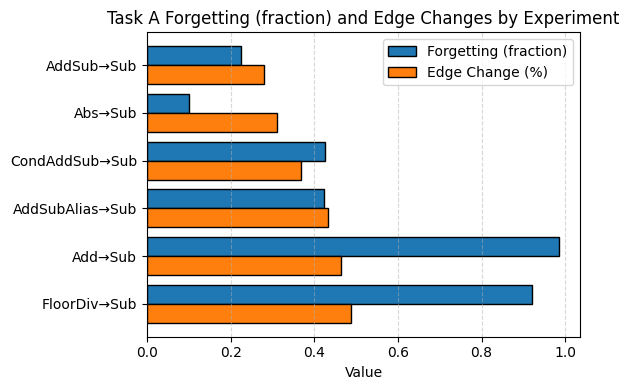

In [51]:
filter_labels = ["Abs→Sub", 
                 "FloorDiv→Sub",
                 "Add→Sub",
                 "AddSubAlias→Sub",
                 "AddSub→Sub",
                 "CondAddSub→Sub"]

df_filtered = df_combined[df_combined["Experiment"].isin(filter_labels)]
df_filtered = df_filtered.sort_values("Task A Edge Change", ascending=True)

labels = df_filtered["Experiment"].tolist()
forgetting = (df_filtered["Task A Forgetting (%)"]).tolist()
edge_change = df_filtered["Task A Edge Change"].tolist()
y = np.arange(len(labels))
height = 0.4

plt.figure(figsize=(6, 4))
plt.barh(y - height/2, forgetting, height=height, edgecolor='black', label='Forgetting (fraction)')
plt.barh(y + height/2, edge_change, height=height, edgecolor='black', label='Edge Change (%)')

plt.yticks(y, labels)
plt.xlabel("Value")
plt.title("Task A Forgetting (fraction) and Edge Changes by Experiment")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm
main_path = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false'
tasks = []
task_labels = []
for root, dirs, files in os.walk(main_path):
    if os.path.basename(root) == "task_b":
        tasks.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels.append(label.replace("->", "→"))

counts_b = []
for task in tqdm(tasks):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints)
    counts_b.append(in_graph_changes[0])


  2%|▏         | 1/56 [00:03<03:23,  3.70s/it]

Top-k Size: 11574, Overlap: 7739, Changes: 3835, Normalized: 0.331


  4%|▎         | 2/56 [00:07<03:15,  3.62s/it]

Top-k Size: 11574, Overlap: 6743, Changes: 4831, Normalized: 0.417


  5%|▌         | 3/56 [00:10<03:10,  3.60s/it]

Top-k Size: 11574, Overlap: 6049, Changes: 5525, Normalized: 0.477


  7%|▋         | 4/56 [00:14<03:07,  3.60s/it]

Top-k Size: 11574, Overlap: 6112, Changes: 5462, Normalized: 0.472


  9%|▉         | 5/56 [00:18<03:06,  3.65s/it]

Top-k Size: 11574, Overlap: 6617, Changes: 4957, Normalized: 0.428


 11%|█         | 6/56 [00:21<03:03,  3.67s/it]

Top-k Size: 11574, Overlap: 6672, Changes: 4902, Normalized: 0.424


 12%|█▎        | 7/56 [00:25<02:59,  3.66s/it]

Top-k Size: 11574, Overlap: 10066, Changes: 1508, Normalized: 0.130


 14%|█▍        | 8/56 [00:29<02:56,  3.68s/it]

Top-k Size: 11574, Overlap: 7446, Changes: 4128, Normalized: 0.357


 16%|█▌        | 9/56 [00:33<02:54,  3.71s/it]

Top-k Size: 11574, Overlap: 6405, Changes: 5169, Normalized: 0.447


 18%|█▊        | 10/56 [00:36<02:52,  3.76s/it]

Top-k Size: 11574, Overlap: 6327, Changes: 5247, Normalized: 0.453


 20%|█▉        | 11/56 [00:40<02:46,  3.71s/it]

Top-k Size: 11574, Overlap: 6642, Changes: 4932, Normalized: 0.426


 21%|██▏       | 12/56 [00:46<03:08,  4.29s/it]

Top-k Size: 11574, Overlap: 6038, Changes: 5536, Normalized: 0.478


 23%|██▎       | 13/56 [00:50<03:02,  4.25s/it]

Top-k Size: 11574, Overlap: 5700, Changes: 5874, Normalized: 0.508


 25%|██▌       | 14/56 [00:53<02:49,  4.04s/it]

Top-k Size: 11574, Overlap: 7470, Changes: 4104, Normalized: 0.355


 27%|██▋       | 15/56 [00:57<02:41,  3.94s/it]

Top-k Size: 11574, Overlap: 9356, Changes: 2218, Normalized: 0.192


 29%|██▊       | 16/56 [01:01<02:36,  3.90s/it]

Top-k Size: 11574, Overlap: 8247, Changes: 3327, Normalized: 0.287


 30%|███       | 17/56 [01:04<02:28,  3.80s/it]

Top-k Size: 11574, Overlap: 6947, Changes: 4627, Normalized: 0.400


 32%|███▏      | 18/56 [01:08<02:23,  3.77s/it]

Top-k Size: 11574, Overlap: 5779, Changes: 5795, Normalized: 0.501


 34%|███▍      | 19/56 [01:12<02:18,  3.76s/it]

Top-k Size: 11574, Overlap: 6811, Changes: 4763, Normalized: 0.412


 36%|███▌      | 20/56 [01:16<02:17,  3.83s/it]

Top-k Size: 11574, Overlap: 10130, Changes: 1444, Normalized: 0.125


 38%|███▊      | 21/56 [01:20<02:17,  3.93s/it]

Top-k Size: 11574, Overlap: 5997, Changes: 5577, Normalized: 0.482


 39%|███▉      | 22/56 [01:24<02:12,  3.91s/it]

Top-k Size: 11574, Overlap: 6323, Changes: 5251, Normalized: 0.454


 41%|████      | 23/56 [01:28<02:13,  4.05s/it]

Top-k Size: 11574, Overlap: 7903, Changes: 3671, Normalized: 0.317


 43%|████▎     | 24/56 [01:33<02:20,  4.39s/it]

Top-k Size: 11574, Overlap: 8082, Changes: 3492, Normalized: 0.302


 45%|████▍     | 25/56 [01:37<02:09,  4.18s/it]

Top-k Size: 11574, Overlap: 7343, Changes: 4231, Normalized: 0.366


 46%|████▋     | 26/56 [01:41<02:01,  4.05s/it]

Top-k Size: 11574, Overlap: 6025, Changes: 5549, Normalized: 0.479


 48%|████▊     | 27/56 [01:45<01:54,  3.96s/it]

Top-k Size: 11574, Overlap: 8623, Changes: 2951, Normalized: 0.255


 50%|█████     | 28/56 [01:48<01:48,  3.88s/it]

Top-k Size: 11574, Overlap: 7052, Changes: 4522, Normalized: 0.391


 52%|█████▏    | 29/56 [01:52<01:42,  3.78s/it]

Top-k Size: 11574, Overlap: 7168, Changes: 4406, Normalized: 0.381


 54%|█████▎    | 30/56 [01:56<01:40,  3.85s/it]

Top-k Size: 11574, Overlap: 7985, Changes: 3589, Normalized: 0.310


 55%|█████▌    | 31/56 [02:00<01:37,  3.88s/it]

Top-k Size: 11574, Overlap: 6185, Changes: 5389, Normalized: 0.466


 57%|█████▋    | 32/56 [02:03<01:31,  3.82s/it]

Top-k Size: 11574, Overlap: 8277, Changes: 3297, Normalized: 0.285


 59%|█████▉    | 33/56 [02:08<01:29,  3.90s/it]

Top-k Size: 11574, Overlap: 6637, Changes: 4937, Normalized: 0.427


 61%|██████    | 34/56 [02:11<01:25,  3.88s/it]

Top-k Size: 11574, Overlap: 6407, Changes: 5167, Normalized: 0.446


 62%|██████▎   | 35/56 [02:16<01:23,  3.97s/it]

Top-k Size: 11574, Overlap: 6103, Changes: 5471, Normalized: 0.473


 64%|██████▍   | 36/56 [02:20<01:21,  4.07s/it]

Top-k Size: 11574, Overlap: 7694, Changes: 3880, Normalized: 0.335


 66%|██████▌   | 37/56 [02:24<01:15,  3.95s/it]

Top-k Size: 11574, Overlap: 8052, Changes: 3522, Normalized: 0.304


 68%|██████▊   | 38/56 [02:27<01:09,  3.89s/it]

Top-k Size: 11574, Overlap: 5899, Changes: 5675, Normalized: 0.490


 70%|██████▉   | 39/56 [02:31<01:03,  3.76s/it]

Top-k Size: 11574, Overlap: 6243, Changes: 5331, Normalized: 0.461


 71%|███████▏  | 40/56 [02:34<00:59,  3.74s/it]

Top-k Size: 11574, Overlap: 6242, Changes: 5332, Normalized: 0.461


 73%|███████▎  | 41/56 [02:38<00:55,  3.73s/it]

Top-k Size: 11574, Overlap: 6378, Changes: 5196, Normalized: 0.449


 75%|███████▌  | 42/56 [02:42<00:51,  3.66s/it]

Top-k Size: 11574, Overlap: 6785, Changes: 4789, Normalized: 0.414


 77%|███████▋  | 43/56 [02:45<00:47,  3.67s/it]

Top-k Size: 11574, Overlap: 7272, Changes: 4302, Normalized: 0.372


 79%|███████▊  | 44/56 [02:49<00:43,  3.62s/it]

Top-k Size: 11574, Overlap: 7437, Changes: 4137, Normalized: 0.357


 80%|████████  | 45/56 [02:53<00:42,  3.88s/it]

Top-k Size: 11574, Overlap: 7028, Changes: 4546, Normalized: 0.393


 82%|████████▏ | 46/56 [02:59<00:43,  4.33s/it]

Top-k Size: 11574, Overlap: 6699, Changes: 4875, Normalized: 0.421


 84%|████████▍ | 47/56 [03:03<00:37,  4.16s/it]

Top-k Size: 11574, Overlap: 7061, Changes: 4513, Normalized: 0.390


 86%|████████▌ | 48/56 [03:08<00:35,  4.46s/it]

Top-k Size: 11574, Overlap: 6540, Changes: 5034, Normalized: 0.435


 88%|████████▊ | 49/56 [03:13<00:33,  4.77s/it]

Top-k Size: 11574, Overlap: 6599, Changes: 4975, Normalized: 0.430


 89%|████████▉ | 50/56 [03:17<00:26,  4.45s/it]

Top-k Size: 11574, Overlap: 6835, Changes: 4739, Normalized: 0.409


 91%|█████████ | 51/56 [03:20<00:21,  4.21s/it]

Top-k Size: 11574, Overlap: 8074, Changes: 3500, Normalized: 0.302


 93%|█████████▎| 52/56 [03:24<00:16,  4.05s/it]

Top-k Size: 11574, Overlap: 7420, Changes: 4154, Normalized: 0.359


 95%|█████████▍| 53/56 [03:28<00:11,  3.95s/it]

Top-k Size: 11574, Overlap: 6843, Changes: 4731, Normalized: 0.409


 96%|█████████▋| 54/56 [03:32<00:07,  3.98s/it]

Top-k Size: 11574, Overlap: 6701, Changes: 4873, Normalized: 0.421


 98%|█████████▊| 55/56 [03:36<00:03,  3.91s/it]

Top-k Size: 11574, Overlap: 7009, Changes: 4565, Normalized: 0.394


100%|██████████| 56/56 [03:39<00:00,  3.93s/it]

Top-k Size: 11574, Overlap: 6719, Changes: 4855, Normalized: 0.419


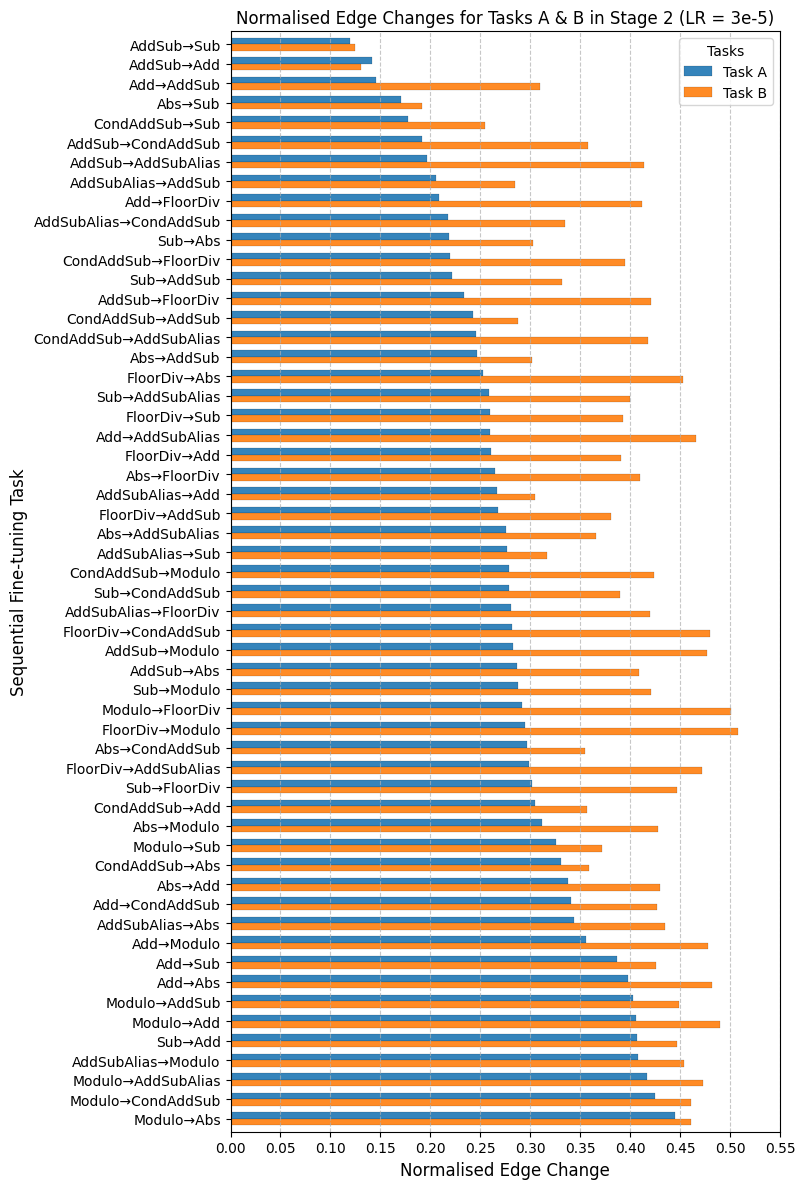

In [21]:
counts_a_arr = np.array(counts)
counts_b_arr = np.array(counts_b)
task_labels_arr = np.array(task_labels)

sorted_idx = np.argsort(counts_a_arr)[::-1]  
sorted_counts_a = counts_a_arr[sorted_idx]
sorted_counts_b = counts_b_arr[sorted_idx]
sorted_labels = task_labels_arr[sorted_idx]
y = np.arange(len(sorted_labels)) * 1.5
plt.figure(figsize=(8,12))

height = 0.5
plt.barh(y + height/2, sorted_counts_a, height=height, label='Task A', edgecolor="black", linewidth=0.1, alpha=0.9)
plt.barh(y - height/2, sorted_counts_b, height=height, label='Task B', edgecolor="black", linewidth=0.1, alpha=0.9)

plt.yticks(y, sorted_labels)
plt.xlabel("Normalised Edge Change", fontsize=12)
plt.ylabel("Sequential Fine-tuning Task", fontsize=12)
plt.title("Normalised Edge Changes for Tasks A & B in Stage 2 (LR = 3e-5)", fontsize=12)
plt.legend(title="Tasks")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
max_val = max(sorted_counts_a.max(), sorted_counts_b.max())
plt.xticks(np.arange(0, max_val + 0.05, 0.05))
plt.ylim(y.min() - 1, y.max() + 1)
plt.savefig("edge_changes_lr_true.pdf", format='pdf', dpi=600)
plt.show()

In [ ]:
main_paths = {
    "LR_false": '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false',
    "LR_true": '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
}

filter_labels = ["Abs→Sub", 
                 "FloorDiv→Sub",
                 "Add→Sub",
                 "AddSubAlias→Sub",
                 "Abs→Sub",
                 "AddSub→Sub"]

def get_counts(main_path, task_type='task_a'):
    tasks, labels = [], []
    for root, dirs, files in os.walk(main_path):
        if os.path.basename(root) == task_type:
            tasks.append(root)
            label = os.path.basename(os.path.dirname(root))
            labels.append(label.replace("->", "→"))
    filtered_tasks, filtered_labels = [], []
    for task, label in zip(tasks, labels):
        if label in filter_labels:
            filtered_tasks.append(task)
            filtered_labels.append(label)
    counts = []
    for task in tqdm(filtered_tasks):
        loaded_checkpoints = load_checkpoints_in_order(task)
        in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
        counts.append(in_graph_changes[0])
    return filtered_labels, counts

labels_a_false, counts_a_false = get_counts(main_paths["LR_false"], 'task_a')
labels_b_false, counts_b_false = get_counts(main_paths["LR_false"], 'task_b')

labels_a_true, counts_a_true = get_counts(main_paths["LR_true"], 'task_a')
labels_b_true, counts_b_true = get_counts(main_paths["LR_true"], 'task_b')

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:22,  5.64s/it]

Top-k Size: 11574, Overlap: 8197, Changes: 3377, Normalized: 0.292


 40%|████      | 2/5 [00:11<00:17,  5.77s/it]

Top-k Size: 11574, Overlap: 6954, Changes: 4620, Normalized: 0.399


 60%|██████    | 3/5 [00:16<00:11,  5.57s/it]

Top-k Size: 11574, Overlap: 8532, Changes: 3042, Normalized: 0.263


 80%|████████  | 4/5 [00:20<00:04,  4.92s/it]

Top-k Size: 11574, Overlap: 8266, Changes: 3308, Normalized: 0.286


100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

Top-k Size: 11574, Overlap: 7480, Changes: 4094, Normalized: 0.354



 20%|██        | 1/5 [00:05<00:21,  5.48s/it]

Top-k Size: 11574, Overlap: 7473, Changes: 4101, Normalized: 0.354


 40%|████      | 2/5 [00:11<00:16,  5.66s/it]

Top-k Size: 11574, Overlap: 7323, Changes: 4251, Normalized: 0.367


 60%|██████    | 3/5 [00:15<00:09,  4.87s/it]

Top-k Size: 11574, Overlap: 7281, Changes: 4293, Normalized: 0.371


 80%|████████  | 4/5 [00:18<00:04,  4.40s/it]

Top-k Size: 11574, Overlap: 6321, Changes: 5253, Normalized: 0.454


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


Top-k Size: 11574, Overlap: 6509, Changes: 5065, Normalized: 0.438


 20%|██        | 1/5 [00:03<00:12,  3.24s/it]

Top-k Size: 11574, Overlap: 9006, Changes: 2568, Normalized: 0.222


 40%|████      | 2/5 [00:06<00:10,  3.54s/it]

Top-k Size: 11574, Overlap: 8723, Changes: 2851, Normalized: 0.246


 60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

Top-k Size: 11574, Overlap: 9886, Changes: 1688, Normalized: 0.146


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

Top-k Size: 11574, Overlap: 9302, Changes: 2272, Normalized: 0.196


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


Top-k Size: 11574, Overlap: 9359, Changes: 2215, Normalized: 0.191


 20%|██        | 1/5 [00:03<00:13,  3.41s/it]

Top-k Size: 11574, Overlap: 7739, Changes: 3835, Normalized: 0.331


 40%|████      | 2/5 [00:07<00:10,  3.65s/it]

Top-k Size: 11574, Overlap: 8082, Changes: 3492, Normalized: 0.302


 60%|██████    | 3/5 [00:10<00:07,  3.65s/it]

Top-k Size: 11574, Overlap: 7985, Changes: 3589, Normalized: 0.310


 80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

Top-k Size: 11574, Overlap: 6785, Changes: 4789, Normalized: 0.414


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]

Top-k Size: 11574, Overlap: 7437, Changes: 4137, Normalized: 0.357


In [32]:
sorted_data = sorted(zip(labels_a_false, counts_a_false), key=lambda x: x[1])

labels_sorted = [lbl for lbl, _ in sorted_data]
counts_a_false_sorted = [val for _, val in sorted_data]
counts_b_false_sorted = [counts_b_false[labels_b_false.index(lbl)] for lbl in labels_sorted]
counts_a_true_sorted = [counts_a_true[labels_a_true.index(lbl)] for lbl in labels_sorted]
counts_b_true_sorted = [counts_b_true[labels_b_true.index(lbl)] for lbl in labels_sorted]

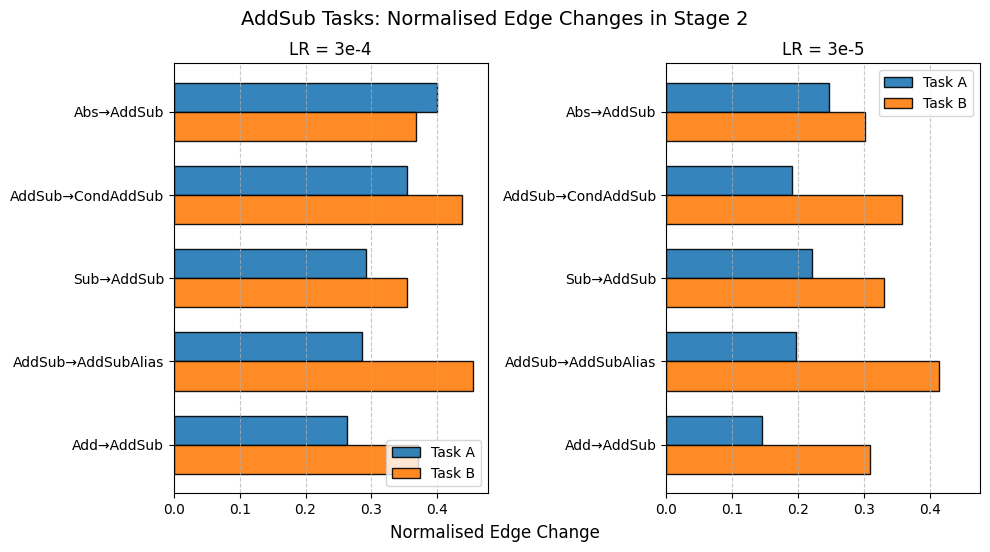

In [34]:
y = np.arange(len(labels_sorted))
height = 0.35

fig, axes = plt.subplots(1, 2, figsize=(10,6), sharex=True)
axes[0].barh(y + height/2, counts_a_false_sorted, height,  # Task A
             color="#1f77b4", edgecolor="black", alpha=0.9, label="Task A")
axes[0].barh(y - height/2, counts_b_false_sorted, height,  # Task B
             color="#ff7f0e", edgecolor="black", alpha=0.9, label="Task B")
axes[0].set_yticks(y)
axes[0].set_yticklabels(labels_sorted)
axes[0].set_title("LR = 3e-4")
axes[0].legend()
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].barh(y + height/2, counts_a_true_sorted, height,  # Task A
             color="#1f77b4", edgecolor="black", alpha=0.9, label="Task A")
axes[1].barh(y - height/2, counts_b_true_sorted, height,  # Task B
             color="#ff7f0e", edgecolor="black", alpha=0.9, label="Task B")
axes[1].set_yticks(y)
axes[1].set_yticklabels(labels_sorted)
axes[1].set_title("LR = 3e-5")
axes[1].legend()
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle("AddSub Tasks: Normalised Edge Changes in Stage 2", fontsize=14, y=0.92)
fig.text(0.5, 0.04, "Normalised Edge Change", ha='center', fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("edge_changes_addsub_task.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def calculate_edge_jaccard_topk(checkpoints, topk_percent=0.05):
    sims = []

    def topk_edges(edges, percent):
        k = max(1, int(len(edges) * percent))
        sorted_edges = sorted(edges.items(), key=lambda item: abs(item[1].get('score', 0)), reverse=True)
        top_edges = set(edge for edge, data in sorted_edges[:k])
        return top_edges

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']

        prev_top = topk_edges(prev_edges, topk_percent)
        curr_top = topk_edges(curr_edges, topk_percent)

        intersection = len(prev_top & curr_top)
        union = len(prev_top | curr_top)
        jaccard = intersection / union if union > 0 else 0.0

        sims.append(jaccard)
        print(f"Step {i}: Jaccard={jaccard:.3f}, |∩|={intersection}, |∪|={union}")

    return sims

In [ ]:
def get_tasks_and_labels(main_path, task_type='task_a'):
    tasks, labels = [], []
    for root, dirs, files in os.walk(main_path):
        if os.path.basename(root) == task_type:
            tasks.append(root)
            label = os.path.basename(os.path.dirname(root))
            labels.append(label.replace("->", "→"))

    filtered_tasks, filtered_labels = [], []
    for task, label in zip(tasks, labels):
        if label in filter_labels:
            filtered_tasks.append(task)
            filtered_labels.append(label)

    return filtered_labels, filtered_tasks

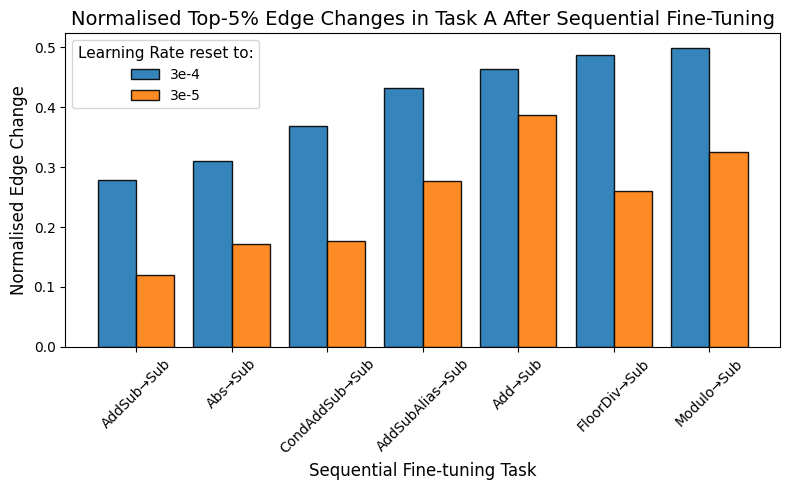

In [201]:
x = np.arange(len(filtered_labels))
width = 0.4

plt.figure(figsize=(8,5))

plt.bar(x - width/2, counts, width, color="#1f77b4", edgecolor="black", label="3e-4", alpha=0.9)
plt.bar(x + width/2, counts2_sorted, width, color="#ff7f0e", edgecolor="black", label="3e-5", alpha=0.9)

plt.xticks(x, filtered_labels, rotation=45, ha="center", fontsize=10)
plt.ylabel("Normalised Edge Change", fontsize=12)
plt.xlabel("Sequential Fine-tuning Task", fontsize=12)
plt.title("Normalised Top-5% Edge Changes in Task A After Sequential Fine-Tuning", fontsize=14)
plt.legend(title="Learning Rate reset to:", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig("/homes/rje41/mech-interp-ft/output/sub_edge_change.pdf", format='pdf', dpi=600)
plt.show()

In [160]:
main_path = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false'
tasks = []
task_labels = []
for root, dirs, files in os.walk(main_path):
    if os.path.basename(root) == "task_b":
        tasks.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels.append(label.replace("->", "→"))

filter_labels = ["AddSub→Sub", "Add→Sub", "Abs→Sub", "CondAddSub→Sub", "AddSubAlias→Sub",'FloorDiv→Sub','Modulo→Sub']
filtered_tasks = []
filtered_labels = []

for task, label in zip(tasks, task_labels):
    if label in filter_labels:
        filtered_tasks.append(task)
        filtered_labels.append(label)

counts = []
for task in tqdm(filtered_tasks):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
    counts.append(in_graph_changes[0])

filtered_labels, counts = zip(*sorted(zip(filtered_labels, counts), key=lambda x: x[1]))

main_path2 = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
tasks2 = []
task_labels2 = []
for root, dirs, files in os.walk(main_path2):
    if os.path.basename(root) == "task_b":
        tasks2.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels2.append(label.replace("->", "→"))

filtered_tasks2 = []
filtered_labels2 = []

for task, label in zip(tasks2, task_labels2):
    if label in filter_labels: 
        filtered_tasks2.append(task)
        filtered_labels2.append(label)

counts2 = []
for task in tqdm(filtered_tasks2):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
    counts2.append(in_graph_changes[0])

order = [filtered_labels.index(lbl) for lbl in filtered_labels2]
counts2_sorted = [counts2[filtered_labels2.index(lbl)] for lbl in filtered_labels]

x = np.arange(len(filtered_labels))
width = 0.3  # smaller width

 14%|█▍        | 1/7 [00:04<00:29,  4.92s/it]

Top-k Size: 11574, Overlap: 5962, Changes: 5612, Normalized: 0.485


 29%|██▊       | 2/7 [00:08<00:20,  4.14s/it]

Top-k Size: 11574, Overlap: 7890, Changes: 3684, Normalized: 0.318


 43%|████▎     | 3/7 [00:14<00:19,  4.94s/it]

Top-k Size: 11574, Overlap: 8629, Changes: 2945, Normalized: 0.254


 57%|█████▋    | 4/7 [00:20<00:15,  5.23s/it]

Top-k Size: 11574, Overlap: 6494, Changes: 5080, Normalized: 0.439


 71%|███████▏  | 5/7 [00:25<00:10,  5.42s/it]

Top-k Size: 11574, Overlap: 7273, Changes: 4301, Normalized: 0.372


 86%|████████▌ | 6/7 [00:31<00:05,  5.52s/it]

Top-k Size: 11574, Overlap: 5773, Changes: 5801, Normalized: 0.501


100%|██████████| 7/7 [00:37<00:00,  5.32s/it]


Top-k Size: 11574, Overlap: 6177, Changes: 5397, Normalized: 0.466


 14%|█▍        | 1/7 [00:05<00:33,  5.56s/it]

Top-k Size: 11574, Overlap: 6642, Changes: 4932, Normalized: 0.426


 29%|██▊       | 2/7 [00:11<00:28,  5.66s/it]

Top-k Size: 11574, Overlap: 9356, Changes: 2218, Normalized: 0.192


 43%|████▎     | 3/7 [00:17<00:22,  5.69s/it]

Top-k Size: 11574, Overlap: 10130, Changes: 1444, Normalized: 0.125


 57%|█████▋    | 4/7 [00:22<00:17,  5.71s/it]

Top-k Size: 11574, Overlap: 7903, Changes: 3671, Normalized: 0.317


 71%|███████▏  | 5/7 [00:28<00:11,  5.61s/it]

Top-k Size: 11574, Overlap: 8623, Changes: 2951, Normalized: 0.255


 86%|████████▌ | 6/7 [00:32<00:05,  5.15s/it]

Top-k Size: 11574, Overlap: 7272, Changes: 4302, Normalized: 0.372


100%|██████████| 7/7 [00:36<00:00,  5.15s/it]

Top-k Size: 11574, Overlap: 7028, Changes: 4546, Normalized: 0.393


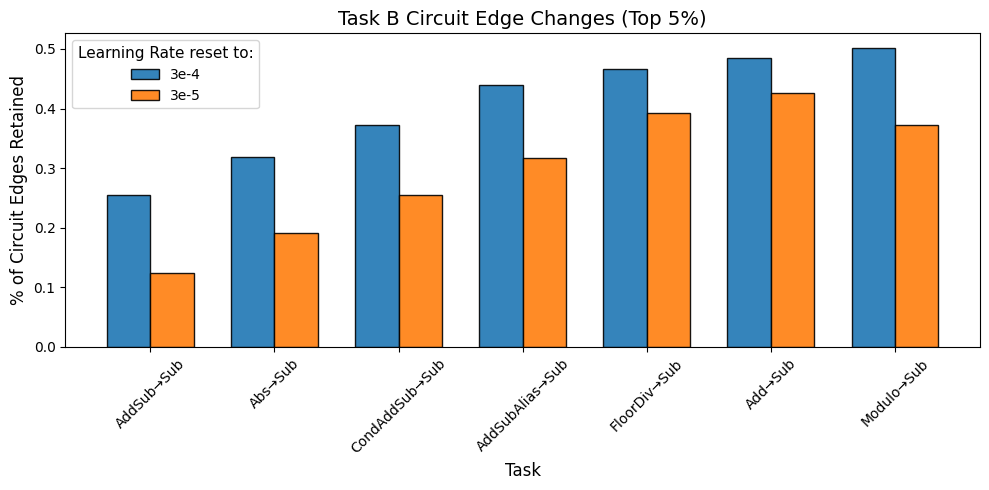

In [161]:
x = np.arange(len(filtered_labels))
width = 0.35 

plt.figure(figsize=(10,5))

plt.bar(x - width/2, counts, width, color="#1f77b4", edgecolor="black", label="3e-4", alpha=0.9)
plt.bar(x + width/2, counts2_sorted, width, color="#ff7f0e", edgecolor="black", label="3e-5", alpha=0.9)

plt.xticks(x, filtered_labels, rotation=45, ha="center", fontsize=10)
plt.ylabel("% of Circuit Edges Retained", fontsize=12)
plt.xlabel("Task", fontsize=12)
plt.title("Task B Circuit Edge Changes (Top 5%)", fontsize=14)
plt.legend(title="Learning Rate reset to:", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

In [17]:
main_path = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false'
tasks = []
task_labels = []
for root, dirs, files in os.walk(main_path):
    if os.path.basename(root) == "task_a":
        tasks.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels.append(label.replace("->", "→"))

filter_labels = ["Add→Sub", "Add→AddSub", "Sub→AddSub", "AddSub→AddSubAlias", "AddSub→CondAddSub","AddSubAlias→AddSub"]
filtered_tasks = []
filtered_labels = []

for task, label in zip(tasks, task_labels):
    if label in filter_labels:
        filtered_tasks.append(task)
        filtered_labels.append(label)

counts = []
for task in tqdm(filtered_tasks):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
    counts.append(in_graph_changes[0])

filtered_labels, counts = zip(*sorted(zip(filtered_labels, counts), key=lambda x: x[1]))

main_path2 = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
tasks2 = []
task_labels2 = []
for root, dirs, files in os.walk(main_path2):
    if os.path.basename(root) == "task_a":
        tasks2.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels2.append(label.replace("->", "→"))

filtered_tasks2 = []
filtered_labels2 = []

for task, label in zip(tasks2, task_labels2):
    if label in filter_labels: 
        filtered_tasks2.append(task)
        filtered_labels2.append(label)

counts2 = []
for task in tqdm(filtered_tasks2):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
    counts2.append(in_graph_changes[0])

order = [filtered_labels.index(lbl) for lbl in filtered_labels2]
counts2_sorted = [counts2[filtered_labels2.index(lbl)] for lbl in filtered_labels]

x = np.arange(len(filtered_labels))
width = 0.3  # smaller width

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:05<00:27,  5.55s/it]

Top-k Size: 11574, Overlap: 8197, Changes: 3377, Normalized: 0.292


 33%|███▎      | 2/6 [00:11<00:22,  5.65s/it]

Top-k Size: 11574, Overlap: 6201, Changes: 5373, Normalized: 0.464


 50%|█████     | 3/6 [00:17<00:17,  5.70s/it]

Top-k Size: 11574, Overlap: 8532, Changes: 3042, Normalized: 0.263


 67%|██████▋   | 4/6 [00:22<00:11,  5.72s/it]

Top-k Size: 11574, Overlap: 7258, Changes: 4316, Normalized: 0.373


 83%|████████▎ | 5/6 [00:28<00:05,  5.65s/it]

Top-k Size: 11574, Overlap: 8266, Changes: 3308, Normalized: 0.286


100%|██████████| 6/6 [00:34<00:00,  5.67s/it]


Top-k Size: 11574, Overlap: 7480, Changes: 4094, Normalized: 0.354


 17%|█▋        | 1/6 [00:05<00:28,  5.62s/it]

Top-k Size: 11574, Overlap: 9006, Changes: 2568, Normalized: 0.222


 33%|███▎      | 2/6 [00:11<00:22,  5.63s/it]

Top-k Size: 11574, Overlap: 7099, Changes: 4475, Normalized: 0.387


 50%|█████     | 3/6 [00:16<00:16,  5.60s/it]

Top-k Size: 11574, Overlap: 9886, Changes: 1688, Normalized: 0.146


 67%|██████▋   | 4/6 [00:22<00:11,  5.63s/it]

Top-k Size: 11574, Overlap: 9197, Changes: 2377, Normalized: 0.205


 83%|████████▎ | 5/6 [00:28<00:05,  5.59s/it]

Top-k Size: 11574, Overlap: 9302, Changes: 2272, Normalized: 0.196


100%|██████████| 6/6 [00:34<00:00,  5.69s/it]

Top-k Size: 11574, Overlap: 9359, Changes: 2215, Normalized: 0.191


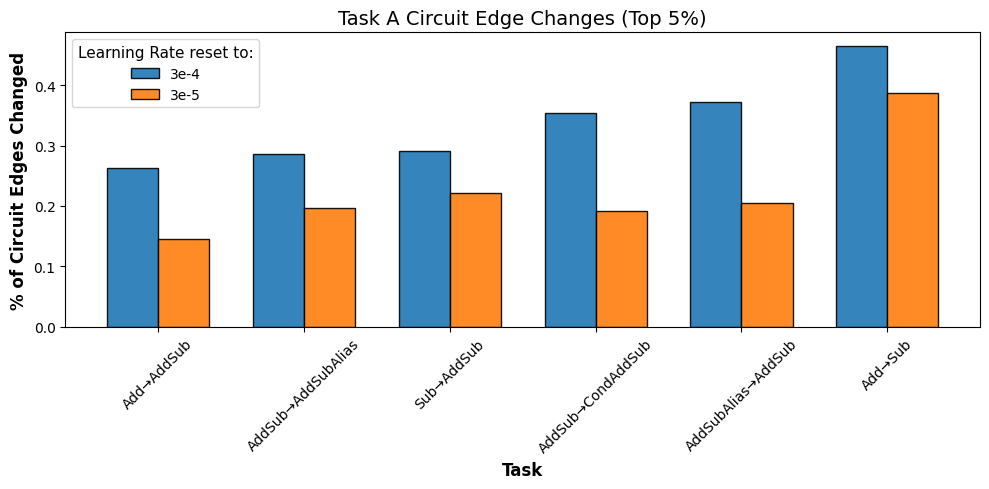

In [18]:
x = np.arange(len(filtered_labels))
width = 0.35 

plt.figure(figsize=(10,5))

plt.bar(x - width/2, counts, width, color="#1f77b4", edgecolor="black", label="3e-4", alpha=0.9)
plt.bar(x + width/2, counts2_sorted, width, color="#ff7f0e", edgecolor="black", label="3e-5", alpha=0.9)


plt.xticks(x, filtered_labels, rotation=45, ha="center", fontsize=10)
plt.ylabel("% of Circuit Edges Changed", fontsize=12, fontweight='bold')
plt.xlabel("Task", fontsize=12, fontweight='bold')
plt.title("Task A Circuit Edge Changes (Top 5%)", fontsize=14)
plt.legend(title="Learning Rate reset to:", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

In [19]:
main_path = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false'
tasks = []
task_labels = []
for root, dirs, files in os.walk(main_path):
    if os.path.basename(root) == "task_b":
        tasks.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels.append(label.replace("->", "→"))

filter_labels = ["Add→Sub", "Add→AddSub", "Sub→AddSub", "AddSub→AddSubAlias", "AddSub→CondAddSub","AddSubAlias→AddSub"]
filtered_tasks = []
filtered_labels = []

for task, label in zip(tasks, task_labels):
    if label in filter_labels:
        filtered_tasks.append(task)
        filtered_labels.append(label)

counts = []
for task in tqdm(filtered_tasks):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
    counts.append(in_graph_changes[0])

filtered_labels, counts = zip(*sorted(zip(filtered_labels, counts), key=lambda x: x[1]))

main_path2 = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
tasks2 = []
task_labels2 = []
for root, dirs, files in os.walk(main_path2):
    if os.path.basename(root) == "task_b":
        tasks2.append(root)
        label = os.path.basename(os.path.dirname(root))
        task_labels2.append(label.replace("->", "→"))

filtered_tasks2 = []
filtered_labels2 = []

for task, label in zip(tasks2, task_labels2):
    if label in filter_labels: 
        filtered_tasks2.append(task)
        filtered_labels2.append(label)

counts2 = []
for task in tqdm(filtered_tasks2):
    loaded_checkpoints = load_checkpoints_in_order(task)
    in_graph_changes = calculate_edge_changes_topk(loaded_checkpoints, 0.05)
    counts2.append(in_graph_changes[0])

order = [filtered_labels.index(lbl) for lbl in filtered_labels2]
counts2_sorted = [counts2[filtered_labels2.index(lbl)] for lbl in filtered_labels]

x = np.arange(len(filtered_labels))
width = 0.3  # smaller width

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:05<00:28,  5.69s/it]

Top-k Size: 11574, Overlap: 7473, Changes: 4101, Normalized: 0.354


 33%|███▎      | 2/6 [00:11<00:22,  5.71s/it]

Top-k Size: 11574, Overlap: 5962, Changes: 5612, Normalized: 0.485


 50%|█████     | 3/6 [00:17<00:17,  5.72s/it]

Top-k Size: 11574, Overlap: 7281, Changes: 4293, Normalized: 0.371


 67%|██████▋   | 4/6 [00:22<00:11,  5.77s/it]

Top-k Size: 11574, Overlap: 6870, Changes: 4704, Normalized: 0.406


 83%|████████▎ | 5/6 [00:28<00:05,  5.65s/it]

Top-k Size: 11574, Overlap: 6321, Changes: 5253, Normalized: 0.454


100%|██████████| 6/6 [00:34<00:00,  5.69s/it]


Top-k Size: 11574, Overlap: 6509, Changes: 5065, Normalized: 0.438


 17%|█▋        | 1/6 [00:05<00:27,  5.47s/it]

Top-k Size: 11574, Overlap: 7739, Changes: 3835, Normalized: 0.331


 33%|███▎      | 2/6 [00:11<00:22,  5.53s/it]

Top-k Size: 11574, Overlap: 6642, Changes: 4932, Normalized: 0.426


 50%|█████     | 3/6 [00:16<00:16,  5.53s/it]

Top-k Size: 11574, Overlap: 7985, Changes: 3589, Normalized: 0.310


 67%|██████▋   | 4/6 [00:22<00:10,  5.49s/it]

Top-k Size: 11574, Overlap: 8277, Changes: 3297, Normalized: 0.285


 83%|████████▎ | 5/6 [00:27<00:05,  5.52s/it]

Top-k Size: 11574, Overlap: 6785, Changes: 4789, Normalized: 0.414


100%|██████████| 6/6 [00:33<00:00,  5.52s/it]

Top-k Size: 11574, Overlap: 7437, Changes: 4137, Normalized: 0.357


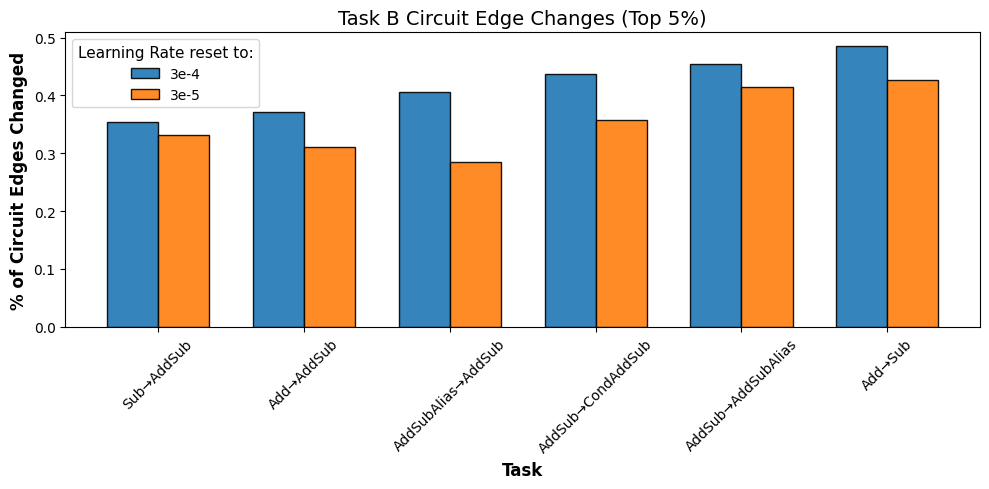

In [20]:
x = np.arange(len(filtered_labels))
width = 0.35 

plt.figure(figsize=(10,5))

plt.bar(x - width/2, counts, width, color="#1f77b4", edgecolor="black", label="3e-4", alpha=0.9)
plt.bar(x + width/2, counts2_sorted, width, color="#ff7f0e", edgecolor="black", label="3e-5", alpha=0.9)


plt.xticks(x, filtered_labels, rotation=45, ha="center", fontsize=10)
plt.ylabel("% of Circuit Edges Changed", fontsize=12, fontweight='bold')
plt.xlabel("Task", fontsize=12, fontweight='bold')
plt.title("Task B Circuit Edge Changes (Top 5%)", fontsize=14)
plt.legend(title="Learning Rate reset to:", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

In [12]:
def visualize_fine_tunings(total_dirs: list, custom_labels=None):
    sns.set_theme(style="whitegrid")
    
    plt.figure(figsize=(8, 5))  # Single plot

    for idx, total_dir in enumerate(total_dirs):
        checkpoints = load_checkpoints_in_order(total_dir)
        edge_changes = calculate_edge_changes_topk(checkpoints,0.01)
        transitions = list(range(1, len(edge_changes) + 1))  # make it a list

        if custom_labels and idx < len(custom_labels):
            label = custom_labels[idx]
        else:
            label = os.path.basename(os.path.dirname(total_dir.rstrip('/')))

        plt.plot(transitions, edge_changes, marker='o', linestyle='-', label=label)

    plt.xlabel('Checkpoint Transition')
    plt.ylabel('Number of Edge Changes')
    plt.title('Edge Changes Across Checkpoints')
    plt.xticks(transitions)
    plt.grid(True)
    plt.legend(title="Runs", fontsize=10)
    plt.tight_layout()
    plt.show()

Top-k Size: 2314, Overlap: 1473, Changes: 841, Normalized: 0.363
Top-k Size: 2314, Overlap: 1815, Changes: 499, Normalized: 0.216
Top-k Size: 2314, Overlap: 1834, Changes: 480, Normalized: 0.207
Top-k Size: 2314, Overlap: 1893, Changes: 421, Normalized: 0.182
Top-k Size: 2314, Overlap: 1912, Changes: 402, Normalized: 0.174
Top-k Size: 2314, Overlap: 1976, Changes: 338, Normalized: 0.146
Top-k Size: 2314, Overlap: 2108, Changes: 206, Normalized: 0.089
Top-k Size: 2314, Overlap: 2174, Changes: 140, Normalized: 0.061
Top-k Size: 2314, Overlap: 2229, Changes: 85, Normalized: 0.037
Top-k Size: 2314, Overlap: 2273, Changes: 41, Normalized: 0.018
Top-k Size: 2314, Overlap: 1193, Changes: 1121, Normalized: 0.484
Top-k Size: 2314, Overlap: 1867, Changes: 447, Normalized: 0.193
Top-k Size: 2314, Overlap: 1972, Changes: 342, Normalized: 0.148
Top-k Size: 2314, Overlap: 2035, Changes: 279, Normalized: 0.121
Top-k Size: 2314, Overlap: 2072, Changes: 242, Normalized: 0.105
Top-k Size: 2314, Overlap:

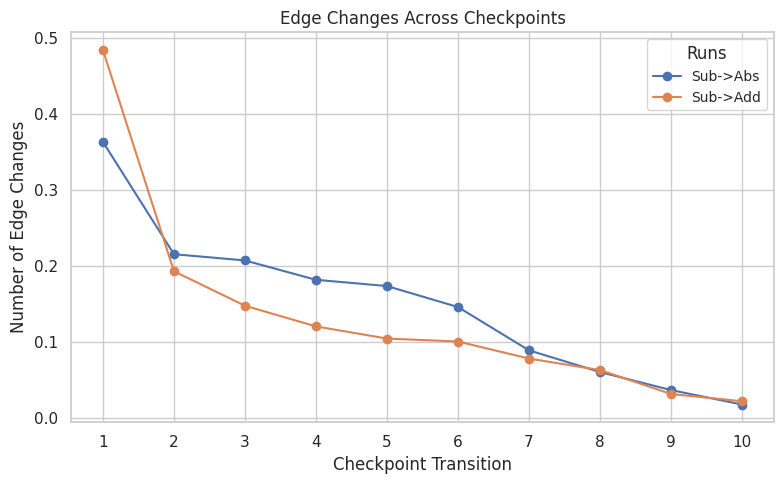

In [14]:
paths = ['/mnt/faster0/rje41/checkpoints/results/experiment_2/individual_task_set_0_run_2/Sub->Abs/task_b',
         '/mnt/faster0/rje41/checkpoints/results/experiment_2/individual_task_set_0_run_2/Sub->Add/task_b']
visualize_fine_tunings(paths, custom_labels=['Sub->Abs','Sub->Add'])

Top-k Size: 2314, Overlap: 802, Changes: 1512, Normalized: 0.653
Top-k Size: 2314, Overlap: 1311, Changes: 1003, Normalized: 0.433
Top-k Size: 2314, Overlap: 1683, Changes: 631, Normalized: 0.273
Top-k Size: 2314, Overlap: 1698, Changes: 616, Normalized: 0.266
Top-k Size: 2314, Overlap: 1771, Changes: 543, Normalized: 0.235
Top-k Size: 2314, Overlap: 1828, Changes: 486, Normalized: 0.210
Top-k Size: 2314, Overlap: 1938, Changes: 376, Normalized: 0.162
Top-k Size: 2314, Overlap: 1983, Changes: 331, Normalized: 0.143
Top-k Size: 2314, Overlap: 2081, Changes: 233, Normalized: 0.101
Top-k Size: 2314, Overlap: 2187, Changes: 127, Normalized: 0.055
Top-k Size: 2314, Overlap: 1473, Changes: 841, Normalized: 0.363
Top-k Size: 2314, Overlap: 1815, Changes: 499, Normalized: 0.216
Top-k Size: 2314, Overlap: 1834, Changes: 480, Normalized: 0.207
Top-k Size: 2314, Overlap: 1893, Changes: 421, Normalized: 0.182
Top-k Size: 2314, Overlap: 1912, Changes: 402, Normalized: 0.174
Top-k Size: 2314, Overla

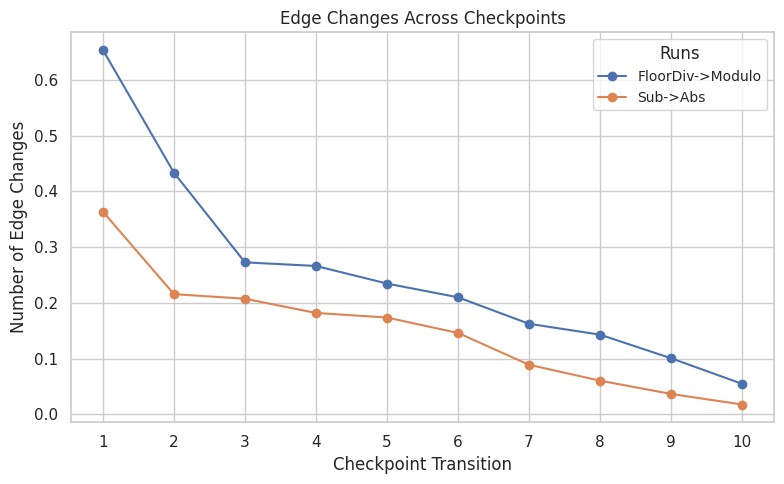

In [17]:
paths = ['/mnt/faster0/rje41/checkpoints/results/experiment_2/individual_task_set_0_run_2/FloorDiv->Modulo/task_b',
         '/mnt/faster0/rje41/checkpoints/results/experiment_2/individual_task_set_0_run_2/Sub->Abs/task_b']
visualize_fine_tunings(paths, custom_labels=['FloorDiv->Modulo','Sub->Abs'])

In [3]:
import json

def load_edges(json_path, percentage=1):
    with open(json_path, 'r') as f:
        graph_data = json.load(f)

    scored_edges = [
    (edge, abs(attrs.get("score", 0)))
    for edge, attrs in graph_data['edges'].items()
    ]

    scored_edges.sort(key=lambda x: abs(x[1]), reverse=True)

    top_n = max(1, int(len(scored_edges) * (percentage / 100)))
    top_edges = {edge for edge, score in scored_edges[:top_n]}
    return top_edges

def jaccard_similarity(set_a, set_b):
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return intersection / union if union != 0 else 0.0

def get_jaccard_similarity_from_graphs(graph_path_1, graph_path_2, percentage=1):
    set_a = load_edges(graph_path_1, percentage)
    set_b = load_edges(graph_path_2, percentage)
    return jaccard_similarity(set_a, set_b)

def get_jaccard_similarity(graph_data_1, graph_data_2):
    set_a = {edge for edge, attrs in graph_data_1['edges'].items() if attrs.get("in_graph", False)}
    set_b = {edge for edge, attrs in graph_data_2['edges'].items() if attrs.get("in_graph", False)}

    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return intersection / union if union != 0 else 0.0

In [4]:
def load_nodes(graph_path):
    with open(graph_path, 'r') as f:
        graph_data = json.load(f)
    return {node for node, attrs in graph_data['nodes'].items() if attrs.get("in_graph", False)}

def jaccard_similarity_nodes(set_a, set_b):
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return intersection / union if union != 0 else 0.0

def get_jaccard_similarity_from_nodes(graph_path_1, graph_path_2):
    set_a = load_nodes(graph_path_1)
    set_b = load_nodes(graph_path_2)
    return jaccard_similarity_nodes(set_a, set_b)

In [6]:
import os
import json
from pathlib import Path

results_folder = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
dirs = [d for d in os.listdir(results_folder) if os.path.isdir(os.path.join(results_folder, d))]

jc_sims_a = []    
jc_sims_ab = []   
accuracy_drops = []


for fine_tune_task in dirs:
    print(f"Processing {fine_tune_task}...")
    fine_tune_task_path = os.path.join(results_folder, fine_tune_task)

    # find subfolders
    task_a_folder = [d for d in os.listdir(fine_tune_task_path) if 'task_a' in d][0]
    task_a_folder_path = os.path.join(fine_tune_task_path, task_a_folder)

    task_b_folder = [d for d in os.listdir(fine_tune_task_path) if 'task_b' in d][0]
    task_b_folder_path = os.path.join(fine_tune_task_path, task_b_folder)

    # checkpoint 0
    checkpoint_0_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_0_a_graph_path = Path(task_a_folder_path) / checkpoint_0_a / 'graph.json'
    checkpoint_0_a_metrics_path = Path(task_a_folder_path) / checkpoint_0_a / 'metrics.json'

    checkpoint_0_b = [d for d in os.listdir(task_b_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_0_b_graph_path = Path(task_b_folder_path) / checkpoint_0_b / 'graph.json'
    checkpoint_0_b_metrics_path = Path(task_b_folder_path) / checkpoint_0_b / 'metrics.json'

    # checkpoint 270
    checkpoint_270_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-270' in d][0]
    checkpoint_270_a_graph_path = Path(task_a_folder_path) / checkpoint_270_a / 'graph.json'
    checkpoint_270_a_metrics_path = Path(task_a_folder_path) / checkpoint_270_a / 'metrics.json'
    
    checkpoint_270_b = [d for d in os.listdir(task_b_folder_path) if 'checkpoint-270' in d][0]
    checkpoint_270_b_graph_path = Path(task_b_folder_path) / checkpoint_270_b / 'graph.json'
    checkpoint_270_b_metrics_path = Path(task_b_folder_path) / checkpoint_270_b / 'metrics.json'

    with open(checkpoint_0_a_metrics_path, "r") as f:
        data = json.load(f)
        accuracy_0 = data['graph_accuracy']

    with open(checkpoint_270_a_metrics_path, "r") as f:
        data = json.load(f)
        accuracy_270 = data['graph_accuracy']

    if accuracy_0 < 0.80:
        continue
    
    # jc_sim_a = get_jaccard_similarity_from_nodes(checkpoint_0_a_graph_path, checkpoint_270_a_graph_path)
    jc_sim_a = get_jaccard_similarity_from_graphs(checkpoint_0_a_graph_path, checkpoint_270_a_graph_path, 5)

    # store results
    jc_sims_a.append(jc_sim_a)
    accuracy_drops.append((accuracy_0- accuracy_270)/accuracy_0)

    print(
        f"{fine_tune_task}: ",
        f"Jaccard(A→A)={jc_sim_a:.4f}, "
        # f"Jaccard(A→B)={jc_sim_ab:.4f}, "
        f"Acc drop={accuracy_0 - accuracy_270:.4f}, "
        f"Start Acc={accuracy_0:.4f}"
    )

Processing Sub->AddSub...
Sub->AddSub:  Jaccard(A→A)=0.6368, Acc drop=0.0100, Start Acc=0.9750
Processing CondAddSub->AddSubAlias...
CondAddSub->AddSubAlias:  Jaccard(A→A)=0.6054, Acc drop=0.0850, Start Acc=0.8150
Processing AddSub->Modulo...
AddSub->Modulo:  Jaccard(A→A)=0.5587, Acc drop=0.2225, Start Acc=0.8875
Processing FloorDiv->AddSubAlias...
FloorDiv->AddSubAlias:  Jaccard(A→A)=0.5397, Acc drop=0.4214, Start Acc=0.9576
Processing Abs->Modulo...
Abs->Modulo:  Jaccard(A→A)=0.5246, Acc drop=0.2875, Start Acc=0.8900
Processing CondAddSub->Modulo...
CondAddSub->Modulo:  Jaccard(A→A)=0.5646, Acc drop=0.2250, Start Acc=0.8150
Processing AddSub->Add...
AddSub->Add:  Jaccard(A→A)=0.7523, Acc drop=0.0325, Start Acc=0.8875
Processing CondAddSub->Add...
CondAddSub->Add:  Jaccard(A→A)=0.5332, Acc drop=0.4225, Start Acc=0.8150
Processing Sub->FloorDiv...
Sub->FloorDiv:  Jaccard(A→A)=0.5364, Acc drop=0.4800, Start Acc=0.9750
Processing FloorDiv->Abs...
FloorDiv->Abs:  Jaccard(A→A)=0.5962, Acc 

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_vs_jaccard(jc_sims, accuracy_drops, x_bounds=None,
                             plot_title="Accuracy Drop vs Jaccard Similarity", save_fig_path=None):
    X = np.array(jc_sims).reshape(-1, 1)
    y = np.array(accuracy_drops)
    
    if x_bounds is not None:
        mask = (X[:, 0] >= x_bounds[0]) & (X[:, 0] <= x_bounds[1])
        X_filtered = X[mask]
        y_filtered = y[mask]
    else:
        X_filtered = X
        y_filtered = y

    model = LinearRegression()
    model.fit(X_filtered, y_filtered)
    y_pred_filtered = model.predict(X_filtered)
    r2 = r2_score(y_filtered, y_pred_filtered)
    r = np.corrcoef(X_filtered[:, 0], y_filtered)[0, 1]

    x_line = np.linspace(X_filtered.min(), X_filtered.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)

    plt.scatter(X, y)
    plt.plot(x_line, y_line, linestyle='--', linewidth=2, color='red',
             label=f"$R^2$={r2:.2f}, r={r:.2f}")

    plt.xlabel("Edge Jaccard Similarity", fontsize=11)
    plt.ylabel("Relative Circuit Accuracy Drop", fontsize=11)
    plt.title(plot_title, fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()

    if save_fig_path:
        plt.savefig(save_fig_path, format='pdf', dpi=600)
    plt.show()

    return model, r2, r

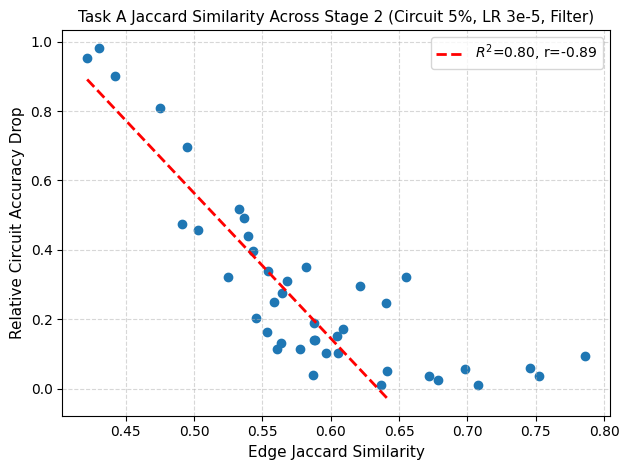

(LinearRegression(), 0.7992976368115492, -0.8940344718250794)

In [35]:
plot_title = "Task A Jaccard Similarity Across Stage 2 (Circuit 5%, LR 3e-5, Filter)"
save_fig_path = 'edge_change_5_lr_true_filter.pdf'
plot_accuracy_vs_jaccard(jc_sims_a, accuracy_drops, plot_title = plot_title, x_bounds=(0.40, 0.65),save_fig_path = save_fig_path)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

def plot_accuracy_vs_jaccard_curve(jc_sims, accuracy_drops, plot_title="Accuracy Drop vs Jaccard Similarity", save_fig_path=None):
    X = np.array(jc_sims)
    y = np.array(accuracy_drops)
    p0 = [max(y), np.median(X), 1]

    popt, pcov = curve_fit(sigmoid, X, y, p0=p0, maxfev=10000)
    y_fit = sigmoid(X, *popt)

    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot
    r = np.corrcoef(X, y)[0, 1]

    X_sorted = np.sort(X)
    plt.scatter(X, y)
    plt.plot(X_sorted, sigmoid(X_sorted, *popt), color='red', linestyle='--',
             label=f"$R^2$ = {r2:.2f}, r = {r:.2f}")
    plt.xlabel("Edge Jaccard Similarity")
    plt.ylabel("Relative Circuit Accuracy Drop")
    plt.title(plot_title, size=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    if save_fig_path:
        plt.savefig(save_fig_path, format='pdf', dpi=600)
    plt.show()

    return popt, r2, r

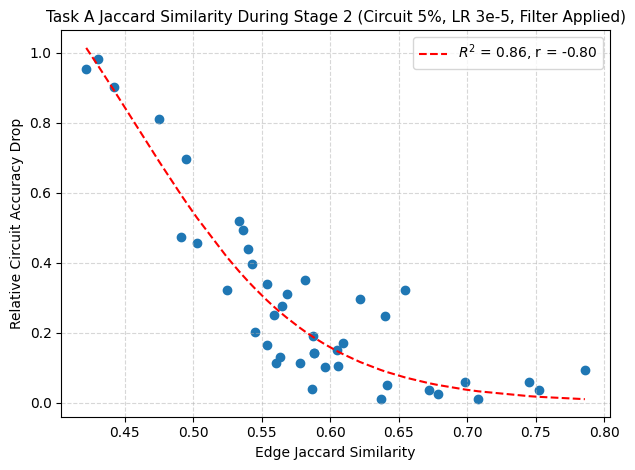

Fitted sigmoid parameters: [  1.60855821   0.45635536 -15.43924541]
R^2 = 0.859, correlation r = -0.803


In [34]:
jc_sims = jc_sims_ab     
accuracy_drops = accuracy_drops 

params, r2, r = plot_accuracy_vs_jaccard_curve(
    jc_sims,
    accuracy_drops,
    plot_title= "Task A Jaccard Similarity During Stage 2 (Circuit 5%, LR 3e-5, Filter Applied)",
    save_fig_path="circuit_change_5_lr_true_filter_fitted.pdf"
)

print("Fitted sigmoid parameters:", params)
print(f"R^2 = {r2:.3f}, correlation r = {r:.3f}")

In [94]:
import os
import json
from pathlib import Path

results_folder = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
dirs = [d for d in os.listdir(results_folder) if os.path.isdir(os.path.join(results_folder, d))]

jc_sims_a = []    
jc_sims_ab = []   
accuracy_drops = []

for fine_tune_task in dirs:
    print(f"Processing {fine_tune_task}...")
    fine_tune_task_path = os.path.join(results_folder, fine_tune_task)

    # find subfolders
    task_a_folder = [d for d in os.listdir(fine_tune_task_path) if 'task_a' in d][0]
    task_a_folder_path = os.path.join(fine_tune_task_path, task_a_folder)

    task_b_folder = [d for d in os.listdir(fine_tune_task_path) if 'task_b' in d][0]
    task_b_folder_path = os.path.join(fine_tune_task_path, task_b_folder)

    # checkpoint 0
    checkpoint_0_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_0_a_graph_path = Path(task_a_folder_path) / checkpoint_0_a / 'graph.json'
    checkpoint_0_a_metrics_path = Path(task_a_folder_path) / checkpoint_0_a / 'metrics.json'

    checkpoint_0_b = [d for d in os.listdir(task_b_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_0_b_graph_path = Path(task_b_folder_path) / checkpoint_0_b / 'graph.json'

    # checkpoint 270
    checkpoint_270_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-270' in d][0]
    checkpoint_270_a_graph_path = Path(task_a_folder_path) / checkpoint_270_a / 'graph.json'
    checkpoint_270_a_metrics_path = Path(task_a_folder_path) / checkpoint_270_a / 'metrics.json'
    checkpoint_270_b = [d for d in os.listdir(task_b_folder_path) if 'checkpoint-270' in d][0]
    checkpoint_270_b_graph_path = Path(task_b_folder_path) / checkpoint_270_b / 'graph.json'

    with open(checkpoint_0_a_metrics_path, "r") as f:
        data = json.load(f)
        accuracy_0 = data['graph_accuracy']

    with open(checkpoint_270_a_metrics_path, "r") as f:
        data = json.load(f)
        accuracy_270 = data['graph_accuracy']

    if accuracy_0 < 0.80:
        continue
    jc_sim_a = get_jaccard_similarity_from_graphs(checkpoint_0_a_graph_path, checkpoint_270_a_graph_path, 1)
    # jc_sim_ab = get_jaccard_similarity_from_graphs(checkpoint_0_a_graph_path, checkpoint_270_b_graph_path, 5)

    # store results
    jc_sims_a.append(jc_sim_a)
    # jc_sims_ab.append(jc_sim_ab)
    accuracy_drops.append((accuracy_0- accuracy_270)/accuracy_0)

    print(
        f"{fine_tune_task}: "
        f"Jaccard(A→A)={jc_sim_a:.4f}, "
        # f"Jaccard(A→B)={jc_sim_ab:.4f}, "
        f"Acc drop={accuracy_0 - accuracy_270:.4f}, "
        f"Start Acc={accuracy_0:.4f}"
    )

Processing Sub->AddSub...
Sub->AddSub: Jaccard(A→A)=0.6744, Acc drop=0.0100, Start Acc=0.9750
Processing CondAddSub->AddSubAlias...
CondAddSub->AddSubAlias: Jaccard(A→A)=0.6176, Acc drop=0.0850, Start Acc=0.8150
Processing AddSub->Modulo...
AddSub->Modulo: Jaccard(A→A)=0.5920, Acc drop=0.2225, Start Acc=0.8875
Processing FloorDiv->AddSubAlias...
FloorDiv->AddSubAlias: Jaccard(A→A)=0.5109, Acc drop=0.4214, Start Acc=0.9576
Processing Abs->Modulo...
Abs->Modulo: Jaccard(A→A)=0.5304, Acc drop=0.2875, Start Acc=0.8900
Processing CondAddSub->Modulo...
CondAddSub->Modulo: Jaccard(A→A)=0.5768, Acc drop=0.2250, Start Acc=0.8150
Processing AddSub->Add...
AddSub->Add: Jaccard(A→A)=0.7973, Acc drop=0.0325, Start Acc=0.8875
Processing CondAddSub->Add...
CondAddSub->Add: Jaccard(A→A)=0.5194, Acc drop=0.4225, Start Acc=0.8150
Processing Sub->FloorDiv...
Sub->FloorDiv: Jaccard(A→A)=0.5370, Acc drop=0.4800, Start Acc=0.9750
Processing FloorDiv->Abs...
FloorDiv->Abs: Jaccard(A→A)=0.6120, Acc drop=0.097

In [95]:
def plot_accuracy_vs_jaccard(jc_sims, accuracy_drops, plot_title="Accuracy Drop vs Jaccard Similarity", save_fig_path=None):
    X = np.array(jc_sims).reshape(-1, 1)
    y = np.array(accuracy_drops)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    r = np.corrcoef(jc_sims, accuracy_drops)[0, 1]

    sorted_idx = np.argsort(X[:, 0])
    X_sorted = X[sorted_idx]
    y_pred_sorted = y_pred[sorted_idx]

    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, edgecolor='k')

    # Regression line
    plt.plot(X_sorted, y_pred_sorted, linestyle='--', linewidth=2,
             label=f"Linear Fit\n$R^2$ = {r2:.2f}, r = {r:.2f}")

    plt.xlabel("Jaccard Similarity", fontsize=11)
    plt.ylabel("Relative Accuracy Drop", fontsize=11)
    plt.title(plot_title, fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()
    if save_fig_path:
        plt.savefig(save_fig_path, format='pdf', dpi=600)
    plt.show()
    plt.show()

    return model, r2, r

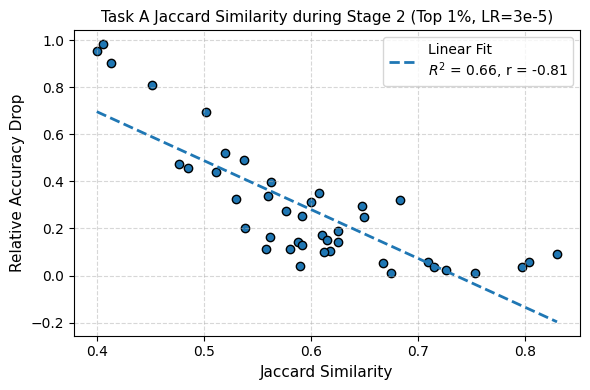

(LinearRegression(), 0.6558090885618685, -0.8098204051281176)

In [96]:
plot_accuracy_vs_jaccard(jc_sims_a, 
                         accuracy_drops, 
                         plot_title = 'Task A Jaccard Similarity during Stage 2 (Top 1%, LR=3e-5)', 
                         save_fig_path="circuit_degradtion_task_a_lr_true_5.pdf")

In [9]:
import os
import json
from pathlib import Path

results_folder = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_true'
dirs = [d for d in os.listdir(results_folder) if os.path.isdir(os.path.join(results_folder, d))]

jc_sims_a = []    
jc_sims_ab = []   
accuracy_drops = []

for fine_tune_task in dirs:
    print(f"Processing {fine_tune_task}...")
    fine_tune_task_path = os.path.join(results_folder, fine_tune_task)

    # find subfolders
    task_a_folder = [d for d in os.listdir(fine_tune_task_path) if 'task_a' in d][0]
    task_a_folder_path = os.path.join(fine_tune_task_path, task_a_folder)

    task_b_folder = [d for d in os.listdir(fine_tune_task_path) if 'task_b' in d][0]
    task_b_folder_path = os.path.join(fine_tune_task_path, task_b_folder)

    # checkpoint 0
    checkpoint_0_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_0_a_graph_path = Path(task_a_folder_path) / checkpoint_0_a / 'graph.json'
    checkpoint_0_a_metrics_path = Path(task_a_folder_path) / checkpoint_0_a / 'metrics.json'

    checkpoint_0_b = [d for d in os.listdir(task_b_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_0_b_graph_path = Path(task_b_folder_path) / checkpoint_0_b / 'graph.json'

    # checkpoint 270
    checkpoint_270_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-270' in d][0]
    checkpoint_270_a_graph_path = Path(task_a_folder_path) / checkpoint_270_a / 'graph.json'
    checkpoint_270_a_metrics_path = Path(task_a_folder_path) / checkpoint_270_a / 'metrics.json'
    checkpoint_270_b = [d for d in os.listdir(task_b_folder_path) if 'checkpoint-270' in d][0]
    checkpoint_270_b_graph_path = Path(task_b_folder_path) / checkpoint_270_b / 'graph.json'

    # load accuracies
    with open(checkpoint_0_a_metrics_path, "r") as f:
        data = json.load(f)
        accuracy_0 = data['graph_accuracy']

    with open(checkpoint_270_a_metrics_path, "r") as f:
        data = json.load(f)
        accuracy_270 = data['graph_accuracy']

    if accuracy_0 < 0.80: #Ignore malformed circuits
        continue

    # compute Jaccard similarities
    jc_sim_a = get_jaccard_similarity_from_graphs(checkpoint_0_a_graph_path, checkpoint_270_a_graph_path, 5)
    # jc_sim_ab = get_jaccard_similarity_from_graphs(checkpoint_0_a_graph_path, checkpoint_270_b_graph_path, 5)

    # store results
    jc_sims_a.append(jc_sim_a)
    # jc_sims_ab.append(jc_sim_ab)
    accuracy_drops.append((accuracy_0- accuracy_270)/accuracy_0)

    print(
        f"{fine_tune_task}: "
        f"Jaccard(A→A)={jc_sim_a:.4f}, "
        # f"Jaccard(A→B)={jc_sim_ab:.4f}, "
        f"Acc drop={accuracy_0 - accuracy_270:.4f}, "
        f"Start Acc={accuracy_0:.4f}"
    )

Processing Sub->AddSub...
Sub->AddSub: Jaccard(A→A)=0.6368, Acc drop=0.0100, Start Acc=0.9750
Processing CondAddSub->AddSubAlias...
CondAddSub->AddSubAlias: Jaccard(A→A)=0.6054, Acc drop=0.0850, Start Acc=0.8150
Processing AddSub->Modulo...
AddSub->Modulo: Jaccard(A→A)=0.5587, Acc drop=0.2225, Start Acc=0.8875
Processing FloorDiv->AddSubAlias...
FloorDiv->AddSubAlias: Jaccard(A→A)=0.5397, Acc drop=0.4214, Start Acc=0.9576
Processing Abs->Modulo...
Abs->Modulo: Jaccard(A→A)=0.5246, Acc drop=0.2875, Start Acc=0.8900
Processing CondAddSub->Modulo...
CondAddSub->Modulo: Jaccard(A→A)=0.5646, Acc drop=0.2250, Start Acc=0.8150
Processing AddSub->Add...
AddSub->Add: Jaccard(A→A)=0.7523, Acc drop=0.0325, Start Acc=0.8875
Processing CondAddSub->Add...
CondAddSub->Add: Jaccard(A→A)=0.5332, Acc drop=0.4225, Start Acc=0.8150
Processing Sub->FloorDiv...
Sub->FloorDiv: Jaccard(A→A)=0.5364, Acc drop=0.4800, Start Acc=0.9750
Processing FloorDiv->Abs...
FloorDiv->Abs: Jaccard(A→A)=0.5962, Acc drop=0.097

R² score: 0.5509
Pearson correlation coefficient (r): -0.7422


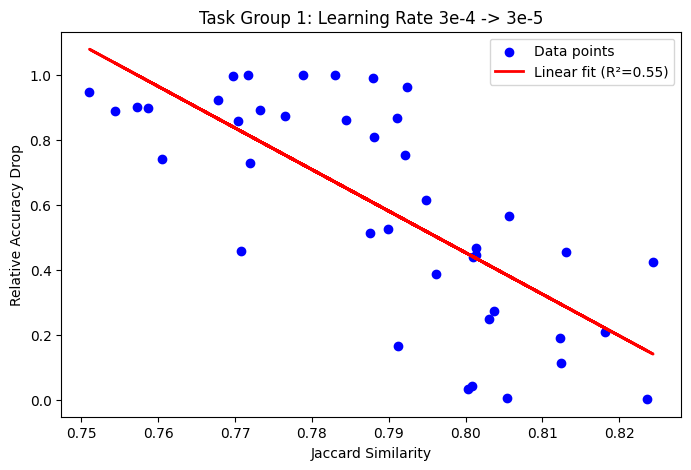

(LinearRegression(), 0.5509124324563142, -0.7422347556240644)

In [27]:
plot_accuracy_vs_jaccard(jc_sims_a, accuracy_drops, plot_title = 'Task Group 1: Learning Rate 3e-4 -> 3e-5')